<center><b><font size=6>Machine Learning for Networks<b><center>

<left><b><font size=4>SSH Shell Attack session<b><left>                                                                   
##### Group 11

In [1]:
!pip install pyarrow
!pip install wordcloud
!pip install gensim
!pip install tensorflow
!pip install nltk

  Using cached pyarrow-12.0.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (39.1 MB)
  Using cached wordcloud-1.9.3-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (489 kB)
  Using cached gensim-4.2.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (24.1 MB)
  Using cached smart_open-6.4.0-py3-none-any.whl (57 kB)
  Using cached tensorflow-2.11.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (588.3 MB)
  Using cached wrapt-1.16.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (77 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
  Using cached tensorboard-2.11.2-py3-none-any.whl (6.0 MB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Using cached tensorflow_io_gcs_filesystem-0.34.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.4 MB)
  Using cached absl_py-2.0.0-py3-none-any.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score
import time

# Models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import multilabel_confusion_matrix, classification_report

#Language Models Exploration 
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense  

# Clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, rand_score

2024-01-11 08:50:13.017746: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 08:50:13.146489: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-11 08:50:13.146518: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-01-11 08:50:13.936867: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

<br>
<left><b><font size=4>Section 1 – Data exploration and pre-processing<b><left>

Dataset with all the SSH sessions

In [3]:
# Loading the dataset
df_original = pd.read_parquet('ssh_attacks.parquet')
df=df_original.copy()
df

session_id                                       full_session  \
0                0  enable ; system ; shell ; sh ; cat /proc/mount...   
1                1  enable ; system ; shell ; sh ; cat /proc/mount...   
2                2  enable ; system ; shell ; sh ; cat /proc/mount...   
3                3  enable ; system ; shell ; sh ; cat /proc/mount...   
4                4  enable ; system ; shell ; sh ; cat /proc/mount...   
...            ...                                                ...   
233030      233042  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233031      233043  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233032      233044  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233033      233045  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233034      233046  cat /proc/cpuinfo | grep name | wc -l ; echo -...   

                         first_timestamp               Set_Fingerprint  
0       2019-06-04 09:45:11.151186+00:00  [Defense Evasion, Discovery]  
1       2019-06-04 09:45:50.396610+00:00  [Defense Evasion, Discovery]  
2       2019-06-04 09:54:41.863315+00:00  [Defense Evasion, Discovery]  
3       2019-06-04 10:22:14.623875+00:00  [Defense Evasion, Discovery]  
4       2019-06-04 10:37:19.725874+00:00  [Defense Evasion, Discovery]  
...                                  ...                           ...  
233030  2020-02-29 23:47:28.217237+00:00      [Discovery, Persistence]  
233031  2020-02-29 23:49:01.009046+00:00      [Discovery, Persistence]  
233032  2020-02-29 23:56:18.827281+00:00      [Discovery, Persistence]  
233033  2020-02-29 23:56:56.263104+00:00      [Discovery, Persistence]  
233034  2020-02-29 23:59:22.199490+00:00      [Discovery, Persistence]  

[233035 rows x 4 columns]

**1. When are the attacks performed? Analyze the temporal series.**

In [17]:
# Convert 'first_timestamp' column to datetime objects
df['first_timestamp'] = pd.to_datetime(df['first_timestamp'])

# Creating a new DataFrame containing only attack instances
# Excluding sessions labeled as "Harmless" with a single label
df_attacks = df.loc[~df["Set_Fingerprint"].apply(lambda x : "Harmless" in x and len(x) == 1)]

# Count the number of attacks per day
# Extract the date from 'first_timestamp', count occurrences, sort by date
attacks_per_day = df_attacks['first_timestamp'].dt.date.value_counts().sort_index().to_frame("Number_of_attacks_per_day")

# Display the resulting DataFrame showing the number of attacks per day
attacks_per_day

Number_of_attacks_per_day
2019-06-04                         82
2019-06-05                        124
2019-06-06                        117
2019-06-07                        121
2019-06-08                        118
...                               ...
2020-02-25                        649
2020-02-26                        483
2020-02-27                        551
2020-02-28                        580
2020-02-29                        627

[257 rows x 1 columns]

The analysis of attack occurrences based on the temporal series of first_timestamp showcases a trend in attack frequency over time.
The dataset has been transformed to interpret the first_timestamp column as datetime objects for accurate temporal analysis. The subsequent process isolates attack instances within the dataset, excluding records tagged as "Harmless" with a single label.
The resulting analysis presents the number of attacks per day:

| Date_time | Attacks |
| --- | --- |
|June 4th, 2019 | 82 attacks |
|June 5th, 2019 | 124 attacks |
|June 6th, 2019 | 117 attacks |
|June 7th, 2019 | 121 attacks |
|June 8th, 2019 | 118 attacks |
| ... (continues with dates up to) |
| February 25th, 2020| 649 attacks |
| February 26th, 2020| 483 attacks |
| February 27th, 2020| 551 attacks |
| February 28th, 2020| 580 attacks |
| February 29th, 2020| 627 attacks |

This temporal series reveals fluctuations in attack intensity over time, with notable spikes and drops in attack occurrences. The observations suggest potential patterns or trends that could be further explored to understand the dynamics of these SSH shell attacks across different periods.

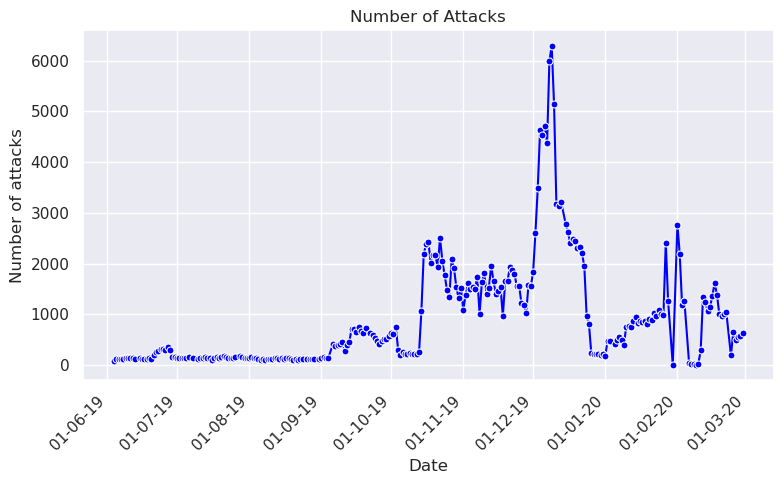

In [20]:
# Set the figure size for the plot
plt.figure(figsize=(8,5))
sns.set_style("darkgrid")

# Create a line plot using seaborn
sns.lineplot(
    data = attacks_per_day,          # Use the 'attacks_per_day' DataFrame for plotting
    x = attacks_per_day.index,       # X-axis represents the timestamp of attacks
    y = "Number_of_attacks_per_day", # Y-axis represents the number of attacks per day
    marker='o',                      # Marker style for data points
    linestyle='-',                   # Style of the line connecting the data points
    color= 'blue',                   # Color of the line
    markersize=5                     # Size of markers
)

# Set plot title and labels for axes
plt.title('Number of Attacks')
plt.xlabel("Date")
plt.ylabel("Number of attacks")

# Format the date on the x-axis to display day-month-year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
plt.xticks(rotation=45, ha='right')

# Ensure proper layout and display the plot
plt.tight_layout()
plt.show()

The visualization depicting attack frequencies over time reveals distinct patterns:

Between June 2019 and September 2019, there is a conspicuous decrease in attack occurrences, indicating a phase of minimal activity. Subsequently, there is a significant surge in attack instances towards the latter part of 2019, signifying a notable rise in both the frequency and intensity of attacks during this period.

This timeline underscores a stark contrast between the relatively quiet phase observed from June to September 2019 and the pronounced escalation in attack activities, particularly notable in the latter months of the year. This shift in trend emphasizes a substantial alteration in attack behavior, marked by an extended period of low activity succeeded by a considerable surge in attack incidents towards the year's end.

Moreover, at the beginning of 2020, there is a noticeable decline in attack occurrences once more. This decline follows the heightened activity observed in late 2019, representing a shift from the increased attack rates back to a decreased frequency as the year transitions into its initial months.

In [19]:
#This code aggregates attack instances per year, creating a DataFrame named attacks_per_year

# Group attack instances by year and count occurrences
attacks_per_year = df_attacks.groupby(df['first_timestamp'].dt.year).size().to_frame("Number_attacks").reset_index()

# Rename columns for clarity
attacks_per_year.rename(columns={"first_timestamp": "Year"}, inplace=True)
attacks_per_year

Year  Number_attacks
0  2019          186468
1  2020           46342

The contrast in attack counts between the two years, with 2019 showing a significantly higher number of attacks compared to 2020, can be reasonably attributed to the limited temporal coverage of the dataset for the year 2020. With data available for only two months of 2020, the reduced number of observations in this period is expected and explains the lower count of attacks for that year compared to the extensive records available for 2019.

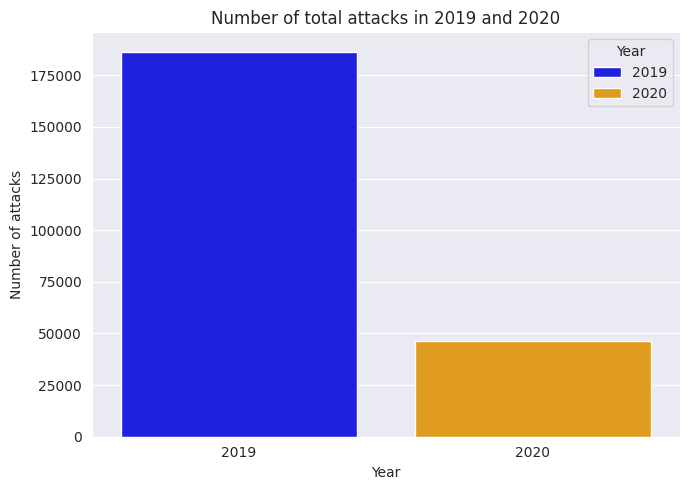

In [7]:
# Set the figure size for the plot
plt.figure(figsize=(7,5))

# Set the figure size for the plot
sns.barplot(
    data = attacks_per_year,   # Use the 'attacks_per_year' DataFrame for plotting
    x = "Year",                # X-axis represents the years (2019 and 2020)
    y = "Number_attacks",      # Y-axis represents the number of attacks
    hue= "Year",
    palette = ['blue','orange']
)

# Set plot labels and title
plt.ylabel("Number of attacks")
plt.title("Number of total attacks in 2019 and 2020")

# Display the plot
plt.tight_layout()
plt.show()

In [4]:
# Filter attack instances for the year 2019
df_attacks_2019 = df_attacks.loc[df_attacks["first_timestamp"].dt.year == 2019]
# Group attacks by month and count occurrences
df_attacks_2019_month = df_attacks_2019.groupby(df_attacks_2019["first_timestamp"].dt.month).size().to_frame("Number_attacks_2019_month").reset_index()

# Filter attack instances for the year 2020
df_attacks_2020 = df_attacks.loc[df_attacks["first_timestamp"].dt.year == 2020]
# Group attacks by month and count occurrences
df_attacks_2020_month = df_attacks_2020.groupby(df_attacks_2020["first_timestamp"].dt.month).size().to_frame("Number_attacks_2020_month").reset_index()

NameError: name 'df_attacks' is not defined

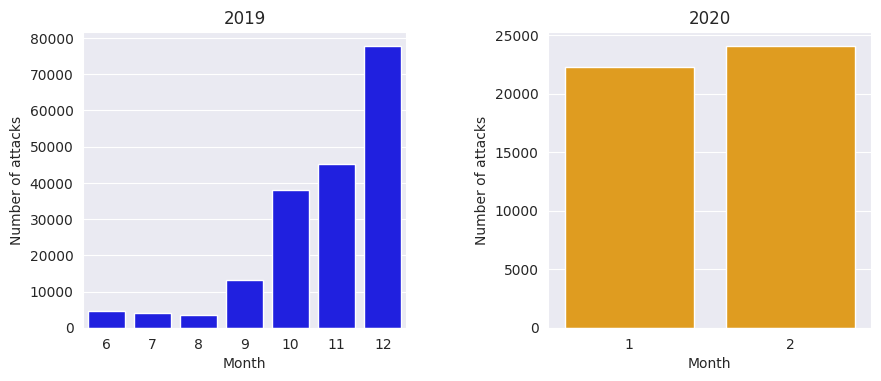

In [9]:
# Set up a figure with two subplots
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")

# Plot for 2019
plt.subplot(1,2,1)
sns.barplot(
    data = df_attacks_2019_month,
    x = "first_timestamp",
    y = "Number_attacks_2019_month",
    color = 'blue'  
)
plt.xlabel("Month")
plt.ylabel("Number of attacks")
plt.title("2019")

# Plot for 2020
plt.subplot(1,2,2)
sns.barplot(
    data = df_attacks_2020_month,
    x = "first_timestamp",
    y = "Number_attacks_2020_month",
    color = 'orange'
)
plt.xlabel("Month")
plt.ylabel("Number of attacks")
plt.title("2020")

# Adjust layout and display the plot
plt.tight_layout(pad = 5)
plt.show()

The bar charts reveal intriguing trends:

- In 2019, there is a noticeable surge in the number of attacks from months 9 to 12. A progressive increase in attack activity is observed during these months, reaching a peak towards the year's end.

- At the onset of 2020, in months 1 and 2, a relatively similar frequency of attacks is noted, approximately representing half the number of attacks compared to month 10 in 2019.

These patterns outline a significant uptick in attack activity towards the end of 2019, followed by a comparatively steady beginning in 2020 with a considerably lower number of attacks compared to the peak period of the previous year.

/tmp/ipykernel_118623/988912449.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


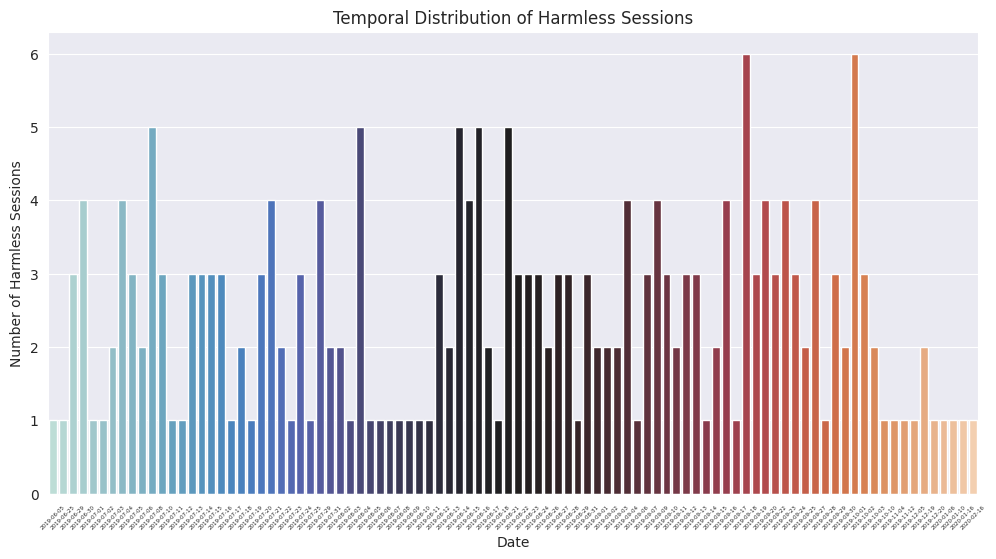

In [10]:
# Filtering harmless sessions based on 'Set_Fingerprint' column
df_harmless = df[df["Set_Fingerprint"].apply(lambda x : "Harmless" in x and len(x) == 1)]

# Counting harmless sessions per day
harmless_per_day = df_harmless['first_timestamp'].dt.date.value_counts().sort_index().to_frame("Number_harmless_per_day")

# Creating a bar plot
plt.figure(figsize=(12, 6))
sns.set_style("darkgrid")
sns.barplot(
    data = harmless_per_day,
    x = harmless_per_day.index, 
    y = "Number_harmless_per_day",
    #hue = harmless_per_day.index,
    #legend = False,
    palette = "icefire"
)
plt.title('Temporal Distribution of Harmless Sessions')
plt.xlabel('Date')
plt.ylabel('Number of Harmless Sessions')
plt.xticks(rotation = 45, fontsize = 4)  # Rotate x-axis labels by 45 degrees

plt.show()

**1.2. Extract features from the attack sessions. How does the empirical distribution of the number of
characters in each session look like? How is the distribution of the number of word per session?**

In [4]:
# Add number of characters and words as features
# Number_characters: Calculates the number of alphanumeric characters in each session.
df['number_characters'] = df['full_session'].apply(lambda x: len([char for char in x if char.isalpha()]))

# Number_words: Computes the number of words (considering only alphanumeric characters) in each session.
df['number_words'] = df['full_session'].apply(lambda x: len([char for char in x.split() if char.isalpha()]))

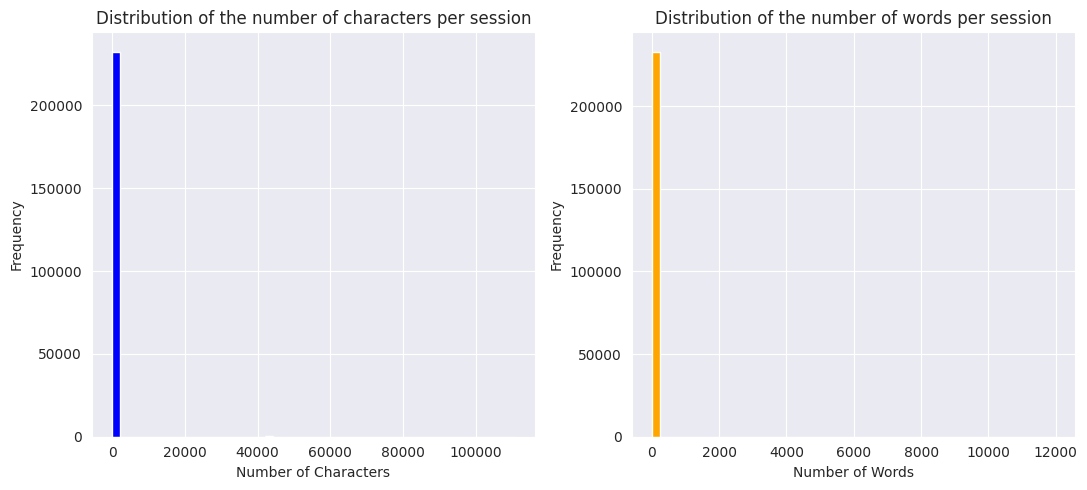

In [12]:
# This code creates two side-by-side histograms:
# Histogram of Character Counts per Session: Displays the distribution of the number of characters in each session. It bins the data into 50 bins.
# Histogram of Word Counts per Session: Shows the distribution of the number of words in each session. It also bins the data into 50 bins.
# These histograms help visualize the distributions of character and word counts within the attack sessions, providing insights into the length and complexity of these sessions in terms of characters and words. 

# Tracking histograms for character and word counts per session.
plt.figure(figsize=(11, 5))

# Histogram for the number of characters per session.
plt.subplot(1, 2, 1)
sns.set_style("darkgrid")
plt.hist(df['number_characters'], bins=50, color = 'blue')
plt.title('Distribution of the number of characters per session')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')


# Histogram for the number of words per session
plt.subplot(1, 2, 2)
plt.hist(df['number_words'], bins = 50 , color = 'orange') 
plt.title('Distribution of the number of words per session')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')


plt.tight_layout()
plt.show()

From the plot, it's possible to see that the distribution of words per session and the distribution of characters per session predominantly concentrate below 2000 words and below 20,000 characters, respectively.

To have a clearer idea of the distribution, we decided to limit the x-axis for both plots so that we can closely examine these two distributions

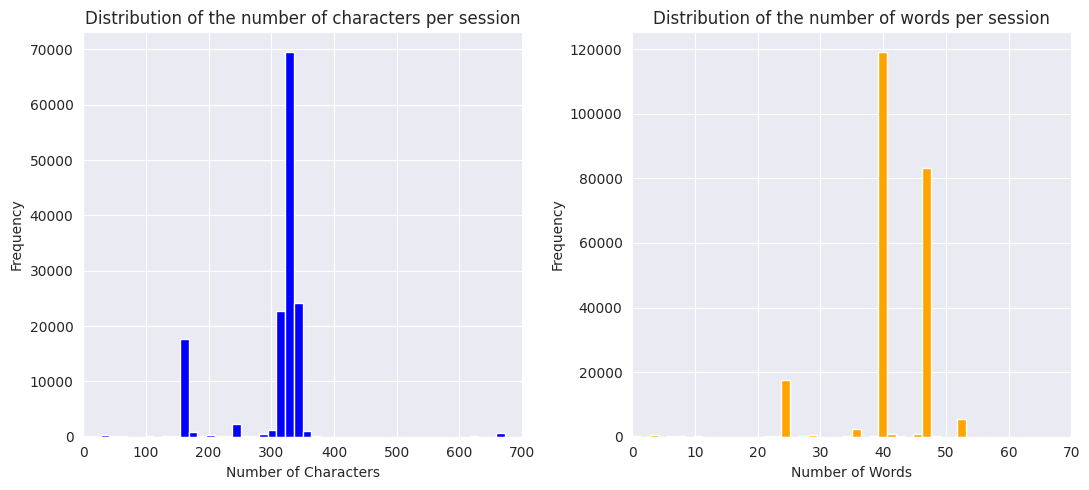

In [13]:
# Tracking histograms for character and word counts per session.
plt.figure(figsize=(11, 5))

# Histogram for the number of characters per session.
plt.subplot(1, 2, 1)
sns.set_style("darkgrid")
plt.hist(df['number_characters'], bins=50, range=(0, 700), color = 'blue') #
plt.title('Distribution of the number of characters per session')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.xlim(0, 700)

# Histogram for the number of words per session
plt.subplot(1, 2, 2)
plt.hist(df['number_words'], bins = 50, range = (0, 70) , color = 'orange') #
plt.title('Distribution of the number of words per session')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xlim(0, 70)

plt.tight_layout()
plt.show()

From the histograms, it is observed that the distribution of character counts per session centers is concentrated around approximately 350 characters.
Moreover, regarding the number of words per session, the distribution frequently peaks around 40 to 48 words. This indicates that sessions often contain this range of word counts, emphasizing a typical occurrence of sessions with this word count range. These insights provide a clear understanding of the common lengths observed within the attack sessions, both in terms of characters and words.

**1.3. What are the most common words in the sessions?**

In [4]:
# Extracting the 'full_session' column from the DataFrame
df_words = df['full_session']

# Joining all text from 'full_session' into a single string
all_text = ' '.join(df['full_session'])

# Splitting the text into individual words
all_words = all_text.split()

# Cleaning the text, leaving only alpha numeric words
cleaning_text = [all_words[i] for i in range(len(all_words)) if all_words[i].isalpha()] 

In [13]:
# Count the occurrences of each word and extract the top 10 most common words
df_list = pd.Series(cleaning_text).value_counts().head(10)

# Identify the most common word and its frequency
most_common_word = df_list.idxmax()    # Most common word
frequency = df_list.max()              # Frequency of the most common word

# Convert the Series of word frequencies to a dictionary
word_freq=df_list.to_dict()
most_common_word

'grep'

The most common word is : 'grep'

In [16]:
# dictionary that holds the frequencies of the top 10 most common words
word_freq

{'grep': 1278484,
 'cat': 1082651,
 'echo': 957748,
 'uname': 639136,
 'name': 638772,
 'rm': 451423,
 'awk': 426372,
 'head': 425586,
 'wc': 425581,
 'ls': 305296}

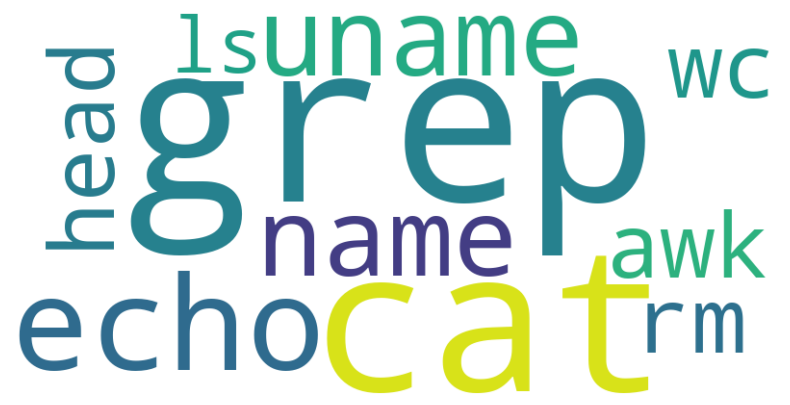

In [17]:
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

 This representation emphasizes words based on their frequency in the sessions. Words that appear more frequently will be displayed larger and more prominently within the WordCloud. The interpolation='bilinear' argument enhances the image quality for better clarity. The plt.axis('off') command removes the axis for a cleaner visual appearance.

**1.4. How are the intents distributed? How many intents per session do you observe? What are the most common intents? How are the intents distributed in time?**

<AxesSubplot:title={'center':'Number of Intents per Sessions'}, xlabel='Sessions', ylabel='Number of Intents'>

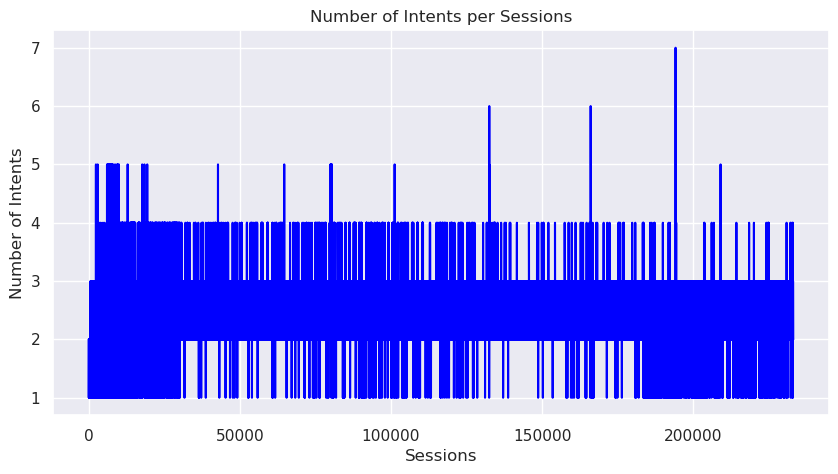

In [21]:
# Extracting relevant columns: session_id and Set_Fingerprint
intents_df = df[["session_id", "Set_Fingerprint"]]

# Expanding the 'Set_Fingerprint' column to individual intents and sessions
intents_df_exploted = intents_df.explode('Set_Fingerprint')

# Grouping by session and counting the number of intents per session
intents_df_grouped = intents_df_exploted.groupby("session_id").size()

# Plotting the distribution of intents per session
intents_df_grouped.plot(
    figsize = (10,5), 
    xlabel = "Sessions", 
    ylabel = "Number of Intents", 
    title = "Number of Intents per Sessions",
    color = 'blue')

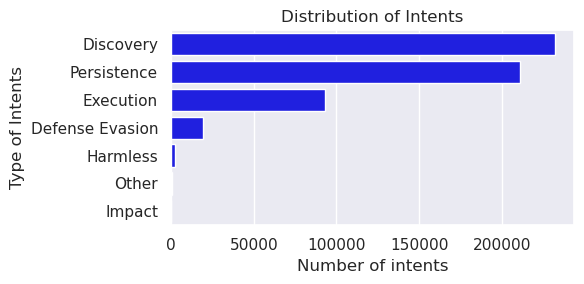

In [15]:
intents = intents_df_exploted.groupby('Set_Fingerprint').count().sort_values(by='session_id', ascending=False)

# Distribution plot of intents 
# Set up Seaborn style
sns.set(style="darkgrid")

# Generate the figures
plt.figure(figsize=(6,3))
sns.barplot(intents, x='session_id', y=intents.index, color='blue', hue_order=intents.index)
plt.title('Distribution of Intents')
plt.xlabel('Number of intents')
plt.ylabel('Type of Intents')

# Show the plot
plt.tight_layout()
plt.show()

The presented bar chart shows the most common intentions found in the dataset; Discovery, Persistence and Execution lead the most used type of attacks for each of the sessions.

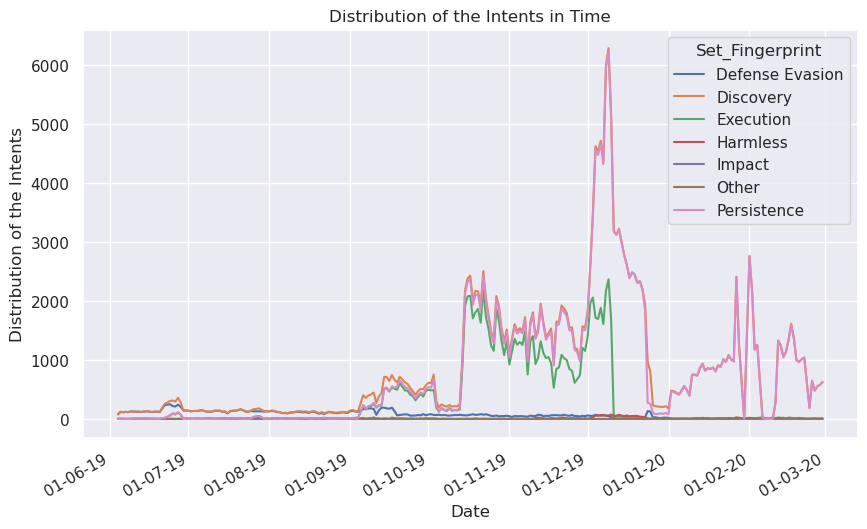

In [22]:
# Explode the 'Set_Fingerprint' column and group by timestamp and intents, filling missing values with 0
df_grouped = df.explode('Set_Fingerprint').groupby([pd.Grouper(key='first_timestamp', freq='D'), 'Set_Fingerprint']).size().unstack().fillna(0)

# Plotting the distribution of intents over time
df_grouped.plot(
    figsize = (10,6), 
    xlabel = "Date", 
    ylabel = "Distribution of the Intents", 
    title = "Distribution of the Intents in Time")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))

The distribution of intents unfolds as follows:

**Defense Evasion**:
No significant peaks noticed, with a few attacks observed between July and September 2019, remaining consistently low alongside 'Harmless', 'Impact', and 'Other' intents.

**Execution**:
Displays a sharp peak towards the end of 2019, notably in the last two months.

**Persistence and Discovery**:
Showcase an intriguing trend, reaching their highest peaks towards the end of 2019. These intents exhibit the highest frequency, notably surging towards the year-end, reaching maximum levels.

**1.5. How can text represented numerically? Try to convert the text into numerical representations
(vectors) through Bag of Words (BoW)**

In [5]:
stop_words = set()
df['full_session'].apply(lambda x: [stop_words.add(character) for character in x if not character.isalpha()])

0         [None, None, None, None, None, None, None, Non...
1         [None, None, None, None, None, None, None, Non...
2         [None, None, None, None, None, None, None, Non...
3         [None, None, None, None, None, None, None, Non...
4         [None, None, None, None, None, None, None, Non...
                                ...                        
233030    [None, None, None, None, None, None, None, Non...
233031    [None, None, None, None, None, None, None, Non...
233032    [None, None, None, None, None, None, None, Non...
233033    [None, None, None, None, None, None, None, Non...
233034    [None, None, None, None, None, None, None, Non...
Name: full_session, Length: 233035, dtype: object

In [6]:
stop_words

{'\x01',
 '\x07',
 '\x0f',
 '\x14',
 '\x16',
 '\x18',
 '\x1a',
 '\x1b',
 ' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}

In [7]:
count_vectorizer = CountVectorizer(stop_words = list(stop_words), min_df = 0.05, max_df = 0.95)
bow = count_vectorizer.fit_transform(df["full_session"])
df["bag_of_words"] = pd.Series(bow.toarray().tolist())
df

session_id                                       full_session  \
0                0  enable ; system ; shell ; sh ; cat /proc/mount...   
1                1  enable ; system ; shell ; sh ; cat /proc/mount...   
2                2  enable ; system ; shell ; sh ; cat /proc/mount...   
3                3  enable ; system ; shell ; sh ; cat /proc/mount...   
4                4  enable ; system ; shell ; sh ; cat /proc/mount...   
...            ...                                                ...   
233030      233042  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233031      233043  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233032      233044  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233033      233045  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233034      233046  cat /proc/cpuinfo | grep name | wc -l ; echo -...   

                         first_timestamp               Set_Fingerprint  \
0       2019-06-04 09:45:11.151186+00:00  [Defense Evasion, Discovery]   
1       2019-06-04 09:45:50.396610+00:00  [Defense Evasion, Discovery]   
2       2019-06-04 09:54:41.863315+00:00  [Defense Evasion, Discovery]   
3       2019-06-04 10:22:14.623875+00:00  [Defense Evasion, Discovery]   
4       2019-06-04 10:37:19.725874+00:00  [Defense Evasion, Discovery]   
...                                  ...                           ...   
233030  2020-02-29 23:47:28.217237+00:00      [Discovery, Persistence]   
233031  2020-02-29 23:49:01.009046+00:00      [Discovery, Persistence]   
233032  2020-02-29 23:56:18.827281+00:00      [Discovery, Persistence]   
233033  2020-02-29 23:56:56.263104+00:00      [Discovery, Persistence]   
233034  2020-02-29 23:59:22.199490+00:00      [Discovery, Persistence]   

        number_characters  number_words  \
0                     167            24   
1                     167            24   
2                     167            24   
3                     167            24   
4                     167            24   
...                   ...           ...   
233030                312            40   
233031                329            40   
233032                337            40   
233033                324            40   
233034                325            40   

                                             bag_of_words  
0       [0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...  
1       [0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...  
2       [0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...  
3       [0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...  
4       [0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...  
...                                                   ...  
233030  [0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ...  
233031  [0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ...  
233032  [0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ...  
233033  [0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ...  
233034  [0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ...  

[233035 rows x 7 columns]

**1.6. Associate each word in each attack session with its TF-IDF value (Term Frequency-Inverse Document Frequency)**

In [8]:
tfidf_vectorizer = TfidfVectorizer(stop_words = list(stop_words), min_df = 0.05, max_df = 0.95)
tfid = tfidf_vectorizer.fit_transform(df["full_session"])
df["tfid"] = pd.Series(tfid.toarray().tolist())
df

session_id                                       full_session  \
0                0  enable ; system ; shell ; sh ; cat /proc/mount...   
1                1  enable ; system ; shell ; sh ; cat /proc/mount...   
2                2  enable ; system ; shell ; sh ; cat /proc/mount...   
3                3  enable ; system ; shell ; sh ; cat /proc/mount...   
4                4  enable ; system ; shell ; sh ; cat /proc/mount...   
...            ...                                                ...   
233030      233042  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233031      233043  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233032      233044  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233033      233045  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233034      233046  cat /proc/cpuinfo | grep name | wc -l ; echo -...   

                         first_timestamp               Set_Fingerprint  \
0       2019-06-04 09:45:11.151186+00:00  [Defense Evasion, Discovery]   
1       2019-06-04 09:45:50.396610+00:00  [Defense Evasion, Discovery]   
2       2019-06-04 09:54:41.863315+00:00  [Defense Evasion, Discovery]   
3       2019-06-04 10:22:14.623875+00:00  [Defense Evasion, Discovery]   
4       2019-06-04 10:37:19.725874+00:00  [Defense Evasion, Discovery]   
...                                  ...                           ...   
233030  2020-02-29 23:47:28.217237+00:00      [Discovery, Persistence]   
233031  2020-02-29 23:49:01.009046+00:00      [Discovery, Persistence]   
233032  2020-02-29 23:56:18.827281+00:00      [Discovery, Persistence]   
233033  2020-02-29 23:56:56.263104+00:00      [Discovery, Persistence]   
233034  2020-02-29 23:59:22.199490+00:00      [Discovery, Persistence]   

        number_characters  number_words  \
0                     167            24   
1                     167            24   
2                     167            24   
3                     167            24   
4                     167            24   
...                   ...           ...   
233030                312            40   
233031                329            40   
233032                337            40   
233033                324            40   
233034                325            40   

                                             bag_of_words  \
0       [0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...   
1       [0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...   
2       [0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...   
3       [0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...   
4       [0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...   
...                                                   ...   
233030  [0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ...   
233031  [0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ...   
233032  [0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ...   
233033  [0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ...   
233034  [0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ...   

                                                     tfid  
0       [0.0, 0.0, 0.1283154980776484, 0.0, 0.0, 0.0, ...  
1       [0.0, 0.0, 0.1283154980776484, 0.0, 0.0, 0.0, ...  
2       [0.0, 0.0, 0.1283154980776484, 0.0, 0.0, 0.0, ...  
3       [0.0, 0.0, 0.1283154980776484, 0.0, 0.0, 0.0, ...  
4       [0.0, 0.0, 0.1283154980776484, 0.0, 0.0, 0.0, ...  
...                                                   ...  
233030  [0.0, 0.07828651838121202, 0.0, 0.117615255528...  
233031  [0.0, 0.07828651838121202, 0.0, 0.117615255528...  
233032  [0.0, 0.07828651838121202, 0.0, 0.117615255528...  
233033  [0.0, 0.07828651838121202, 0.0, 0.117615255528...  
233034  [0.0, 0.07828651838121202, 0.0, 0.117615255528...  

[233035 rows x 8 columns]

In [9]:
tfidf_df = pd.DataFrame(tfid.toarray(), index=df["full_session"].index, columns = list(tfidf_vectorizer.vocabulary_.keys()))
# Concatenate along columns (axis=1)
result_df = pd.concat([df, tfidf_df], axis=1)
result_df
# 61 new features in total

session_id                                       full_session  \
0                0  enable ; system ; shell ; sh ; cat /proc/mount...   
1                1  enable ; system ; shell ; sh ; cat /proc/mount...   
2                2  enable ; system ; shell ; sh ; cat /proc/mount...   
3                3  enable ; system ; shell ; sh ; cat /proc/mount...   
4                4  enable ; system ; shell ; sh ; cat /proc/mount...   
...            ...                                                ...   
233030      233042  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233031      233043  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233032      233044  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233033      233045  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233034      233046  cat /proc/cpuinfo | grep name | wc -l ; echo -...   

                         first_timestamp               Set_Fingerprint  \
0       2019-06-04 09:45:11.151186+00:00  [Defense Evasion, Discovery]   
1       2019-06-04 09:45:50.396610+00:00  [Defense Evasion, Discovery]   
2       2019-06-04 09:54:41.863315+00:00  [Defense Evasion, Discovery]   
3       2019-06-04 10:22:14.623875+00:00  [Defense Evasion, Discovery]   
4       2019-06-04 10:37:19.725874+00:00  [Defense Evasion, Discovery]   
...                                  ...                           ...   
233030  2020-02-29 23:47:28.217237+00:00      [Discovery, Persistence]   
233031  2020-02-29 23:49:01.009046+00:00      [Discovery, Persistence]   
233032  2020-02-29 23:56:18.827281+00:00      [Discovery, Persistence]   
233033  2020-02-29 23:56:56.263104+00:00      [Discovery, Persistence]   
233034  2020-02-29 23:59:22.199490+00:00      [Discovery, Persistence]   

        number_characters  number_words  \
0                     167            24   
1                     167            24   
2                     167            24   
3                     167            24   
4                     167            24   
...                   ...           ...   
233030                312            40   
233031                329            40   
233032                337            40   
233033                324            40   
233034                325            40   

                                             bag_of_words  \
0       [0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...   
1       [0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...   
2       [0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...   
3       [0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...   
4       [0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...   
...                                                   ...   
233030  [0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ...   
233031  [0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ...   
233032  [0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ...   
233033  [0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ...   
233034  [0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ...   

                                                     tfid  enable    system  \
0       [0.0, 0.0, 0.1283154980776484, 0.0, 0.0, 0.0, ...     0.0  0.000000   
1       [0.0, 0.0, 0.1283154980776484, 0.0, 0.0, 0.0, ...     0.0  0.000000   
2       [0.0, 0.0, 0.1283154980776484, 0.0, 0.0, 0.0, ...     0.0  0.000000   
3       [0.0, 0.0, 0.1283154980776484, 0.0, 0.0, 0.0, ...     0.0  0.000000   
4       [0.0, 0.0, 0.1283154980776484, 0.0, 0.0, 0.0, ...     0.0  0.000000   
...                                                   ...     ...       ...   
233030  [0.0, 0.07828651838121202, 0.0, 0.117615255528...     0.0  0.078287   
233031  [0.0, 0.07828651838121202, 0.0, 0.117615255528...     0.0  0.078287   
233032  [0.0, 0.07828651838121202, 0.0, 0.117615255528...     0.0  0.078287   
233033  [0.0, 0.07828651838121202, 0.0, 0.117615255528...     0.0  0.078287   
233034  [0.0, 0.07828651838121202, 0.0, 0.117615255528...     0.0  0.078287   

        ...    passwd     admin        up  

<br>
<b>Correlation Matrix</b>

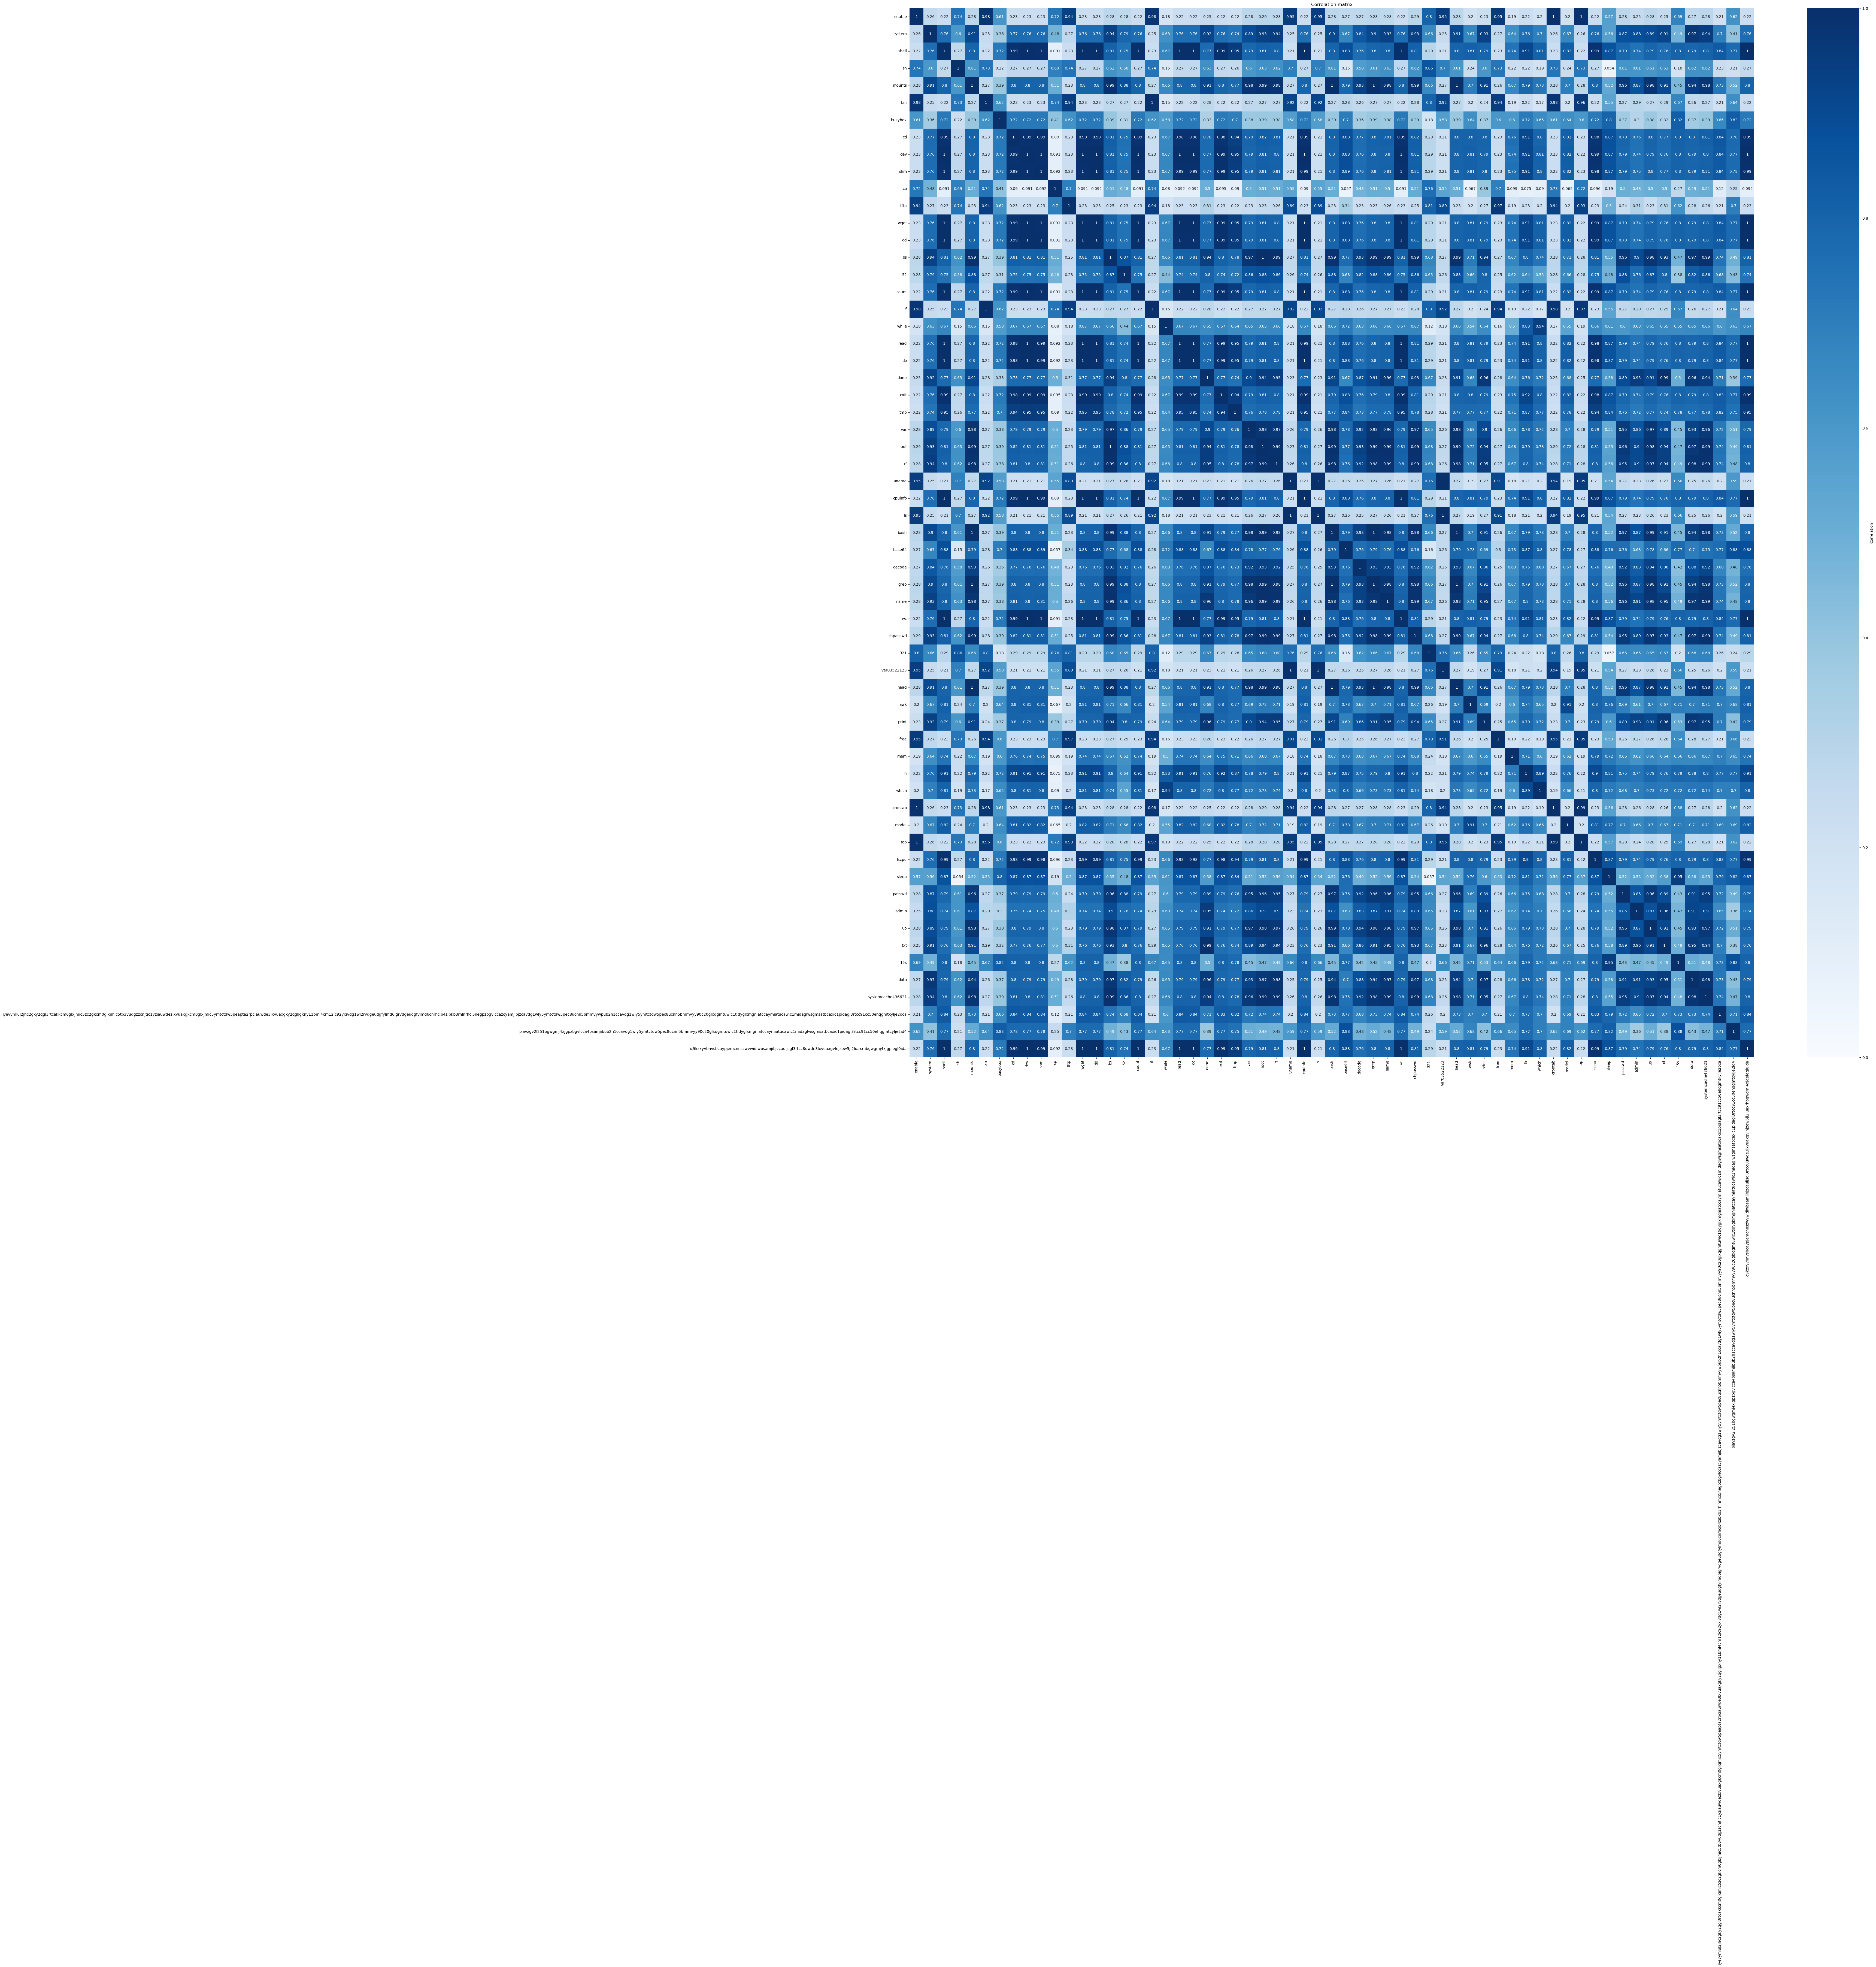

In [10]:
# Compute the correlation matrix
df_class = result_df.copy()
df_features = df_class.drop(columns=["session_id", "full_session", "first_timestamp", "Set_Fingerprint", "number_characters", "number_words", "bag_of_words", "tfid"])
correlation_matrix = df_features.corr().abs()

# Compute the heatmap of the correlation matrix}
plt.figure(figsize=(50,50))
sns.heatmap(correlation_matrix, cmap='Blues', annot=True, vmin=.0, vmax=1, cbar_kws={'label':'Correlation'})
plt.title('Correlation matrix')
plt.show()

In [12]:
# Extract features having a correlation (with a covariance) > 0.98
c = correlation_matrix[correlation_matrix > 0.95]
s = c.unstack()
so = s.sort_values(ascending=False).reset_index()

# Get strongly correlatead features, removing pairs having correlation = 1 because of the diagonal,
# i.e., correlation between one feature and itself"
so = so[(so[0].isnull()==False) & (so["level_0"] != so["level_1"])]
to_be_deleted = []
candidates = list(so["level_0"])

# Get the unique set of features to be deleted
# Notice that we discard one feature per time considering the case where a feature is strongly correlated
# with multiple features
subset_so = so
for candidate in candidates:
    if (candidate in list(subset_so["level_0"])): 
        to_be_deleted.append(candidate) # add the feature to the removed candidates
        # remove the rows where the removed feature is involved
        subset_so = subset_so[(subset_so["level_0"] != candidate) & (subset_so["level_1"] != candidate)] 
print(len(to_be_deleted), 'features to be removed')
to_be_deleted

36 features to be removed


['dev',
 'ls',
 'uname',
 'wget',
 'var03522123',
 'shell',
 'head',
 'mounts',
 'count',
 'wc',
 'if',
 'bin',
 'grep',
 'do',
 'ic9kzxyvbnvsbcaypjemcnnszwvwidiwbsamjibjzcauljsgl3rtcc8uwde3lxvuaxgvlnjzew5jl2luaxrhbgwgmj4xjgplegl0ida',
 'read',
 'dd',
 'bash',
 'cpuinfo',
 'shm',
 'bs',
 'root',
 'top',
 'enable',
 'crontab',
 'name',
 'systemcache436621',
 'chpasswd',
 'rf',
 'exit',
 'cd',
 'txt',
 'done',
 'up',
 'dota',
 'tftp']

In [13]:
df_features = df_features.drop(columns=to_be_deleted)

In [14]:
df_features

system        sh   busybox        cp        52     while       tmp  \
0       0.000000  0.000000  0.000000  0.063164  0.000000  0.125796  0.128216   
1       0.000000  0.000000  0.000000  0.063164  0.000000  0.125796  0.128216   
2       0.000000  0.000000  0.000000  0.063164  0.000000  0.125796  0.128216   
3       0.000000  0.000000  0.000000  0.063164  0.000000  0.125796  0.128216   
4       0.000000  0.000000  0.000000  0.063164  0.000000  0.125796  0.128216   
...          ...       ...       ...       ...       ...       ...       ...   
233030  0.078287  0.117615  0.078694  0.000000  0.077831  0.000000  0.000000   
233031  0.078287  0.117615  0.078694  0.000000  0.077831  0.000000  0.000000   
233032  0.078287  0.117615  0.078694  0.000000  0.077831  0.000000  0.000000   
233033  0.078287  0.117615  0.078694  0.000000  0.077831  0.000000  0.000000   
233034  0.078287  0.117615  0.078694  0.000000  0.077831  0.000000  0.000000   

             var   base64    decode  ...        lh     which     model  \
0       0.000000  0.00000  0.000000  ...  0.126712  0.125966  0.127564   
1       0.000000  0.00000  0.000000  ...  0.126712  0.125966  0.127564   
2       0.000000  0.00000  0.000000  ...  0.126712  0.125966  0.127564   
3       0.000000  0.00000  0.000000  ...  0.126712  0.125966  0.127564   
4       0.000000  0.00000  0.000000  ...  0.126712  0.125966  0.127564   
...          ...      ...       ...  ...       ...       ...       ...   
233030  0.078016  0.15586  0.078079  ...  0.000000  0.000000  0.000000   
233031  0.078016  0.15586  0.078079  ...  0.000000  0.000000  0.000000   
233032  0.078016  0.15586  0.078079  ...  0.000000  0.000000  0.000000   
233033  0.078016  0.15586  0.078079  ...  0.000000  0.000000  0.000000   
233034  0.078016  0.15586  0.078079  ...  0.000000  0.000000  0.000000   

           lscpu     sleep    passwd     admin       15s  \
0       0.127953  0.000000  0.000000  0.000000  0.000000   
1       0.127953  0.000000  0.000000  0.000000  0.000000   
2       0.127953  0.000000  0.000000  0.000000  0.000000   
3       0.127953  0.000000  0.000000  0.000000  0.000000   
4       0.127953  0.000000  0.000000  0.000000  0.000000   
...          ...       ...       ...       ...       ...   
233030  0.000000  0.389004  0.077864  0.078897  0.311856   
233031  0.000000  0.389004  0.077864  0.078897  0.311856   
233032  0.000000  0.389004  0.077864  0.078897  0.311856   
233033  0.000000  0.389004  0.077864  0.078897  0.311856   
233034  0.000000  0.389004  0.077864  0.078897  0.311856   

        iyevymlul2jhc2gky2qgl3rtcakkcm0glxjmic5zc2gkcm0glxjmic5tb3vudgzzcnjtic1yziauwdezlxvuaxgkcm0glxjmic5ymtctdw5peapta2rpciauwde3lxvuaxgky2qgllgxny11bml4cm12ic92yxivdg1wl2rvdgeudgfylmd6igrvdgeudgfylmd6cnrhcib4zibkb3rhlnrhci5negpzbgvlccazcyamjibjzcavdg1wly5ymtctdw5pec8ucnn5bmmvywpub2h1ccavdg1wly5ymtctdw5pec8ucnn5bmmvyy90c20glxqgmtuwic1tidyglxmgniatccaymiatucawic1midaglwsgmsatbcaxic1pidagl3rtcc91cc50ehqgmtkylje2oca  \
0                                                0.126899                                                                                                                                                                                                                                                                                                                                                                             
1                                                0.126899                                                                                                                                                                                                                                                                                                                                                                             
2                                                0.126899                                                                                                                 

In [15]:
print('The final DataFrame has :', df_features.shape[1], 'features.')

The final DataFrame has : 25 features.


In [16]:
result_df_corr = pd.concat([result_df[["session_id", "full_session","first_timestamp","Set_Fingerprint", "bag_of_words","tfid"]], df_features], axis=1)
result_df_corr

session_id                                       full_session  \
0                0  enable ; system ; shell ; sh ; cat /proc/mount...   
1                1  enable ; system ; shell ; sh ; cat /proc/mount...   
2                2  enable ; system ; shell ; sh ; cat /proc/mount...   
3                3  enable ; system ; shell ; sh ; cat /proc/mount...   
4                4  enable ; system ; shell ; sh ; cat /proc/mount...   
...            ...                                                ...   
233030      233042  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233031      233043  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233032      233044  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233033      233045  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233034      233046  cat /proc/cpuinfo | grep name | wc -l ; echo -...   

                         first_timestamp               Set_Fingerprint  \
0       2019-06-04 09:45:11.151186+00:00  [Defense Evasion, Discovery]   
1       2019-06-04 09:45:50.396610+00:00  [Defense Evasion, Discovery]   
2       2019-06-04 09:54:41.863315+00:00  [Defense Evasion, Discovery]   
3       2019-06-04 10:22:14.623875+00:00  [Defense Evasion, Discovery]   
4       2019-06-04 10:37:19.725874+00:00  [Defense Evasion, Discovery]   
...                                  ...                           ...   
233030  2020-02-29 23:47:28.217237+00:00      [Discovery, Persistence]   
233031  2020-02-29 23:49:01.009046+00:00      [Discovery, Persistence]   
233032  2020-02-29 23:56:18.827281+00:00      [Discovery, Persistence]   
233033  2020-02-29 23:56:56.263104+00:00      [Discovery, Persistence]   
233034  2020-02-29 23:59:22.199490+00:00      [Discovery, Persistence]   

                                             bag_of_words  \
0       [0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...   
1       [0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...   
2       [0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...   
3       [0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...   
4       [0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...   
...                                                   ...   
233030  [0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ...   
233031  [0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ...   
233032  [0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ...   
233033  [0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ...   
233034  [0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ...   

                                                     tfid    system        sh  \
0       [0.0, 0.0, 0.1283154980776484, 0.0, 0.0, 0.0, ...  0.000000  0.000000   
1       [0.0, 0.0, 0.1283154980776484, 0.0, 0.0, 0.0, ...  0.000000  0.000000   
2       [0.0, 0.0, 0.1283154980776484, 0.0, 0.0, 0.0, ...  0.000000  0.000000   
3       [0.0, 0.0, 0.1283154980776484, 0.0, 0.0, 0.0, ...  0.000000  0.000000   
4       [0.0, 0.0, 0.1283154980776484, 0.0, 0.0, 0.0, ...  0.000000  0.000000   
...                                                   ...       ...       ...   
233030  [0.0, 0.07828651838121202, 0.0, 0.117615255528...  0.078287  0.117615   
233031  [0.0, 0.07828651838121202, 0.0, 0.117615255528...  0.078287  0.117615   
233032  [0.0, 0.07828651838121202, 0.0, 0.117615255528...  0.078287  0.117615   
233033  [0.0, 0.07828651838121202, 0.0, 0.117615255528...  0.078287  0.117615   
233034  [0.0, 0.07828651838121202, 0.0, 0.117615255528...  0.078287  0.117615   

         busybox        cp  ...        lh     which     model     lscpu  \
0       0.000000  0.063164  ...  0.126712  0.125966  0.127564  0.127953   
1       0.000000  0.063164  ...  0.126712  0.125966  0.127564  0.127953   
2       0.000000  0.063164  ...  0.126712  0.125966  0.127564  0.127953   
3       0.000000  0.063164  ...  0.126712  0.125966  0.127564  0.127953   
4       0.000000  0.063164  ...  0.126712  0.125966  0.127564  0.127953   
...          ...       ...  ...       ...       ...       ...       ...   
233030  0.0

<br>
<left><b><font size=4>Section 2 – Supervised Learning – Classification<b><left>

<br>
<div style="text-align: justify"> Classify the tactics of an attack session, based on the used words in the text and also possibly on time. Notice that each session have multiple labels. Hence you can decompose the problem into multiple binary classification problems. For each attack session, you have to solve the 7 binary classification problem, one for each possible label {'Persistence', 'Discovery', 'Defense Evasion', 'Execution', 'Impact', 'Other', 'Harmless'}. </div><br>

**2.1 Perform a split to segment the dataset into training and test dataset. If you want to standardize your dataset, fit the scaler on training set and transforming both training and test. Notice that the sklearn implementation of tf-idf already performs the standardization.**

In [18]:
features_names = df_features.columns

X_feature = result_df_corr.filter(features_names)
y_feature =  result_df_corr["Set_Fingerprint"]

X_train, X_test, y_train, y_test = train_test_split(
    X_feature,
    y_feature,
    train_size = 0.7,             # 70% of the data is for trainning
    random_state = 42)

In [20]:
print('The size of trainning set is:', len(X_train))
print('The size of test set is:', len(X_test))

The size of trainning set is: 163124
The size of test set is: 69911


In [21]:
X_train

system        sh   busybox        cp        52     while       tmp  \
4699    0.000000  0.000000  0.000000  0.063164  0.000000  0.125796  0.128216   
113772  0.054569  0.000000  0.109705  0.088115  0.054251  0.000000  0.000000   
64201   0.054569  0.000000  0.109705  0.088115  0.054251  0.000000  0.000000   
221592  0.078287  0.117615  0.078694  0.000000  0.077831  0.000000  0.000000   
198673  0.071243  0.428134  0.071614  0.000000  0.070828  0.000000  0.000000   
...          ...       ...       ...       ...       ...       ...       ...   
119879  0.054569  0.000000  0.109705  0.088115  0.054251  0.000000  0.000000   
103694  0.078287  0.117615  0.078694  0.000000  0.077831  0.000000  0.000000   
131932  0.078287  0.117615  0.078694  0.000000  0.077831  0.000000  0.000000   
146867  0.078287  0.117615  0.078694  0.000000  0.077831  0.000000  0.000000   
121958  0.078287  0.117615  0.078694  0.000000  0.077831  0.000000  0.000000   

             var    base64    decode  ...        lh     which     model  \
4699    0.000000  0.000000  0.000000  ...  0.126712  0.125966  0.127564   
113772  0.054380  0.162961  0.054424  ...  0.000000  0.000000  0.000000   
64201   0.054380  0.162961  0.054424  ...  0.000000  0.000000  0.000000   
221592  0.078016  0.155860  0.078079  ...  0.000000  0.000000  0.000000   
198673  0.070997  0.141838  0.071054  ...  0.000000  0.000000  0.000000   
...          ...       ...       ...  ...       ...       ...       ...   
119879  0.054380  0.162961  0.054424  ...  0.000000  0.000000  0.000000   
103694  0.078016  0.155860  0.078079  ...  0.000000  0.000000  0.000000   
131932  0.078016  0.155860  0.078079  ...  0.000000  0.000000  0.000000   
146867  0.078016  0.155860  0.078079  ...  0.000000  0.000000  0.000000   
121958  0.078016  0.155860  0.078079  ...  0.000000  0.000000  0.000000   

           lscpu     sleep    passwd     admin       15s  \
4699    0.127953  0.000000  0.000000  0.000000  0.000000   
113772  0.000000  0.488070  0.054274  0.054994  0.434751   
64201   0.000000  0.488070  0.054274  0.054994  0.434751   
221592  0.000000  0.389004  0.077864  0.078897  0.311856   
198673  0.000000  0.354006  0.070859  0.071798  0.283799   
...          ...       ...       ...       ...       ...   
119879  0.000000  0.488070  0.054274  0.054994  0.434751   
103694  0.000000  0.389004  0.077864  0.078897  0.311856   
131932  0.000000  0.389004  0.077864  0.078897  0.311856   
146867  0.000000  0.389004  0.077864  0.078897  0.311856   
121958  0.000000  0.389004  0.077864  0.078897  0.311856   

        iyevymlul2jhc2gky2qgl3rtcakkcm0glxjmic5zc2gkcm0glxjmic5tb3vudgzzcnjtic1yziauwdezlxvuaxgkcm0glxjmic5ymtctdw5peapta2rpciauwde3lxvuaxgky2qgllgxny11bml4cm12ic92yxivdg1wl2rvdgeudgfylmd6igrvdgeudgfylmd6cnrhcib4zibkb3rhlnrhci5negpzbgvlccazcyamjibjzcavdg1wly5ymtctdw5pec8ucnn5bmmvywpub2h1ccavdg1wly5ymtctdw5pec8ucnn5bmmvyy90c20glxqgmtuwic1tidyglxmgniatccaymiatucawic1midaglwsgmsatbcaxic1pidagl3rtcc91cc50ehqgmtkylje2oca  \
4699                                             0.126899                                                                                                                                                                                                                                                                                                                                                                             
113772                                           0.000000                                                                                                                                                                                                                                                                                                                                                                             
64201                                            0.000000                                                                                                     

### Data Preprocessing

##### Standardization of the Numerical Features

As the TF-IDF pre-processing was applied previously to all the sessions, the data considered as features was already standardized. 

##### Standardization of the Categorical Features

In [31]:
from sklearn.preprocessing import MultiLabelBinarizer

# Use MultiLabelBinarizer to transform the labels
mlb = MultiLabelBinarizer()
y_train_mlb = mlb.fit_transform(y_train)
y_test_mlb = mlb.transform(y_test)

**Preprocessing Techniques** 
<br>
<div style="text-align: justify"> A <b>MultiLabelBinarizer</b> is a transformer that is used for multi-label classification problems, in order to handle the cases where each sample belongs to multiple classes simultaneously. The purpose of MultiLabelBinarizer is to convert a collection of sequences of labels into a binary matrix format. The binary classification of each label in the 'Set_Fingerprint' column was performed by converting the multi-class label matrix into a binary matrix, where each column represents one of the possible classes and each row represents one instance. </div><br>

<div style="text-align: justify"> <b>TF-IDF </b> (explain technique here) </div><br>

<div style="text-align: justify"> MultiLabelBinarizer is used to handle categorical variables before fitting a model, as most machine learning algorithms can only handle numerical data.</div><br>


**2.2 Choose at least 2 ML methods, and perform the model training, with default parameter
configuration, evaluating the performance on both training and test set. Output the confusion
matrix and classification report. Do you observe overfitting or under-fitting? Which model
generates the best performance?**

<br><left><b><font size=4> Random Forest (RF)<b><left>

<div style="text-align: justify">Random Forest (RF) serves as a classification model that constructs a collection of decision trees (DT) using a randomly chosen subset of the given training set. The model aggregates the individual decisions made by each decision tree and combines their votes to make the ultimate prediction.</div>

In [23]:
model_rf = RandomForestClassifier(n_estimators=100) #(n_estimators=30, max_depth=50)

st = time.time()
# Trainning the model
model_rf.fit(X_train, y_train_mlb)
et = time.time()

# get the execution time
elapsed_time = et - st
print(r'Time to train the model:', elapsed_time,'seconds')

Time to train the model: 14.34534740447998 seconds


In [24]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions on training set
y_train_predictions = model_rf.predict(X_train)

# Predictions on test set
y_test_predictions = model_rf.predict(X_test)

In [37]:
from sklearn import metrics

# Evaluate the model's performance on the test data
accu = model_rf.score(X_train, y_train_mlb)
accuracy = metrics.accuracy_score(y_train_mlb, y_train_predictions)
print(f"Accuracy of the 'Random Forest' model for the trainning set: {accuracy:.2f}, {accu:.2f}")

# Evaluate the model's performance on the test data
accu = model_rf.score(X_test, y_test_mlb)
accuracy = metrics.accuracy_score(y_test_mlb, y_test_predictions)
print(f"Accuracy of the 'Random Forest' model for test set: {accuracy:.2f}, {accu:.2f}")

Accuracy of the 'Random Forest' model for the trainning set: 0.99, 0.99
Accuracy of the 'Random Forest' model for test set: 0.98, 0.98


<br>
<left><b><font size=3 >Classification Report<b><left>

##### Training Set

In [38]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Evaluate performance on training set
report_trainning = classification_report(y_train_mlb, y_train_predictions, target_names=mlb.classes_, output_dict=True)
df_report_trainning = pd.DataFrame(report_trainning).transpose()
df_report_trainning

/home/rick_ubuntu/Scrivania/Untitled Folder/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision    recall  f1-score   support
Defense Evasion   0.995177  0.972690  0.983805   13365.0
Discovery         0.999957  0.999840  0.999898  162486.0
Execution         0.999861  0.989495  0.994651   65210.0
Harmless          0.933993  0.184245  0.307776    1536.0
Impact            1.000000  0.720000  0.837209      25.0
Other             1.000000  0.991071  0.995516     224.0
Persistence       0.999594  0.999574  0.999584  147864.0
micro avg         0.999591  0.993855  0.996714  390710.0
macro avg         0.989797  0.836702  0.874063  390710.0
weighted avg      0.999381  0.993855  0.995619  390710.0
samples avg       0.999146  0.994570  0.996252  390710.0

##### Validation Set (Test set)

In [39]:
# Evaluate performance on test set
report_test = classification_report(y_test_mlb, y_test_predictions, target_names=mlb.classes_, output_dict=True)
df_report_test = pd.DataFrame(report_test).transpose()
df_report_test

/home/rick_ubuntu/Scrivania/Untitled Folder/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision    recall  f1-score   support
Defense Evasion   0.993804  0.967874  0.980667    5634.0
Discovery         0.999785  0.999627  0.999706   69659.0
Execution         0.999525  0.987841  0.993649   27717.0
Harmless          0.938053  0.158209  0.270754     670.0
Impact            0.500000  0.500000  0.500000       2.0
Other             1.000000  0.941748  0.970000     103.0
Persistence       0.999464  0.999527  0.999496   63431.0
micro avg         0.999374  0.993153  0.996254  167216.0
macro avg         0.918662  0.793546  0.816324  167216.0
weighted avg      0.999165  0.993153  0.995036  167216.0
samples avg       0.998790  0.993892  0.995646  167216.0

<br>
<left><b><font size=3> Confusion Matrix <b><left>

##### Training Set

In [40]:
confusion_rf_train = multilabel_confusion_matrix(y_train_mlb, y_train_predictions)

# Printing the confusion matrix
for i, label in enumerate(mlb.classes_):
    print(f"Confusion Matrix for '{label}':")
    print(confusion_rf_train[i])
    print()


Confusion Matrix for 'Defense Evasion':
[[149696     63]
 [   365  13000]]

Confusion Matrix for 'Discovery':
[[   631      7]
 [    26 162460]]

Confusion Matrix for 'Execution':
[[97905     9]
 [  685 64525]]

Confusion Matrix for 'Harmless':
[[161568     20]
 [  1253    283]]

Confusion Matrix for 'Impact':
[[163099      0]
 [     7     18]]

Confusion Matrix for 'Other':
[[162900      0]
 [     2    222]]

Confusion Matrix for 'Persistence':
[[ 15200     60]
 [    63 147801]]



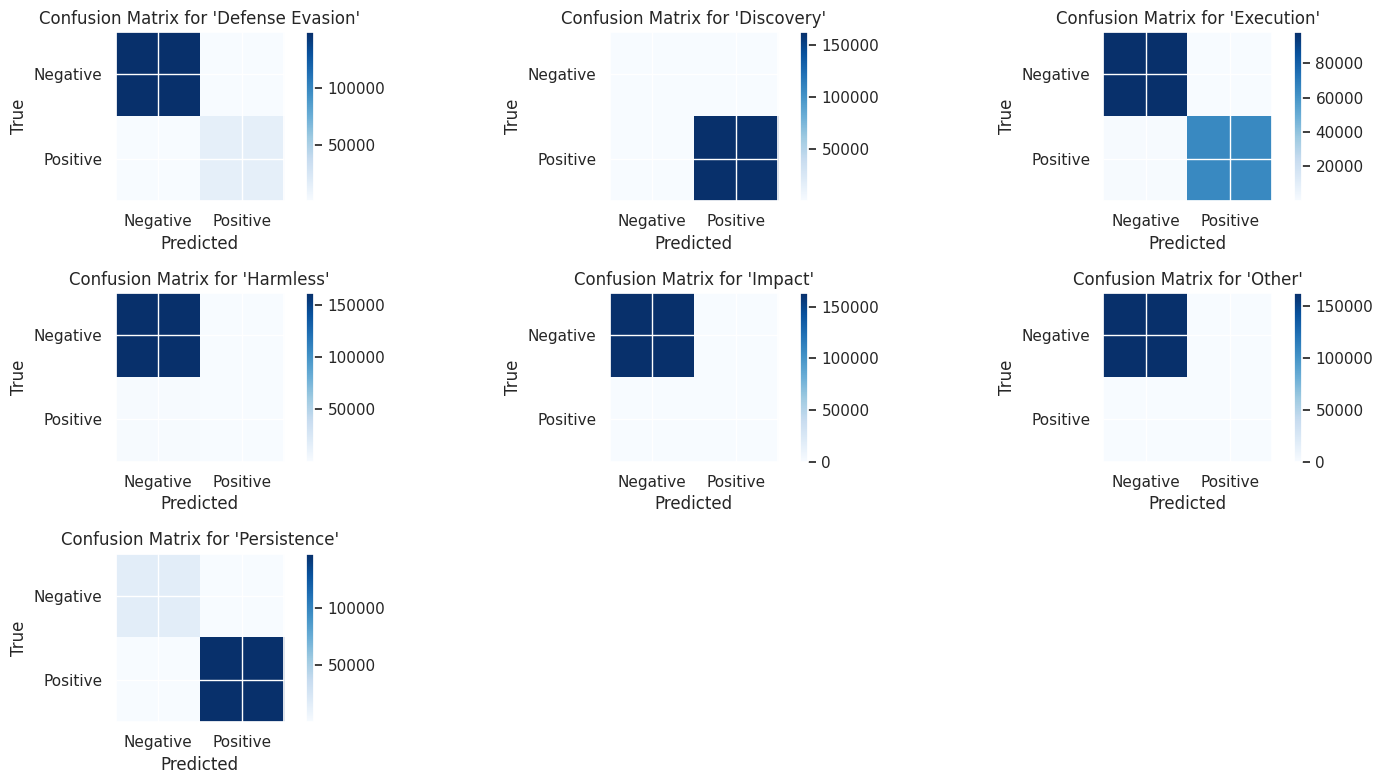

In [41]:
# Plotting the confusion matrix
plt.figure(figsize=(15, 8))
for i, label in enumerate(mlb.classes_):
    plt.subplot(3, 3, i + 1)
    plt.title(f"Confusion Matrix for '{label}'")
    plt.imshow(confusion_rf_train[i], cmap='Blues', interpolation='nearest')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(np.arange(2), ['Negative', 'Positive'])
    plt.yticks(np.arange(2), ['Negative', 'Positive'])

plt.tight_layout()
plt.show()

##### Validation Set

In [42]:
confusion_rf_test = multilabel_confusion_matrix(y_test_mlb, y_test_predictions)

# Printing the confusion matrix
for i, label in enumerate(mlb.classes_):
    print(f"Confusion Matrix for '{label}':")
    print(confusion_rf_test[i])
    print()    

Confusion Matrix for 'Defense Evasion':
[[64243    34]
 [  181  5453]]

Confusion Matrix for 'Discovery':
[[  237    15]
 [   26 69633]]

Confusion Matrix for 'Execution':
[[42181    13]
 [  337 27380]]

Confusion Matrix for 'Harmless':
[[69234     7]
 [  564   106]]

Confusion Matrix for 'Impact':
[[69908     1]
 [    1     1]]

Confusion Matrix for 'Other':
[[69808     0]
 [    6    97]]

Confusion Matrix for 'Persistence':
[[ 6446    34]
 [   30 63401]]



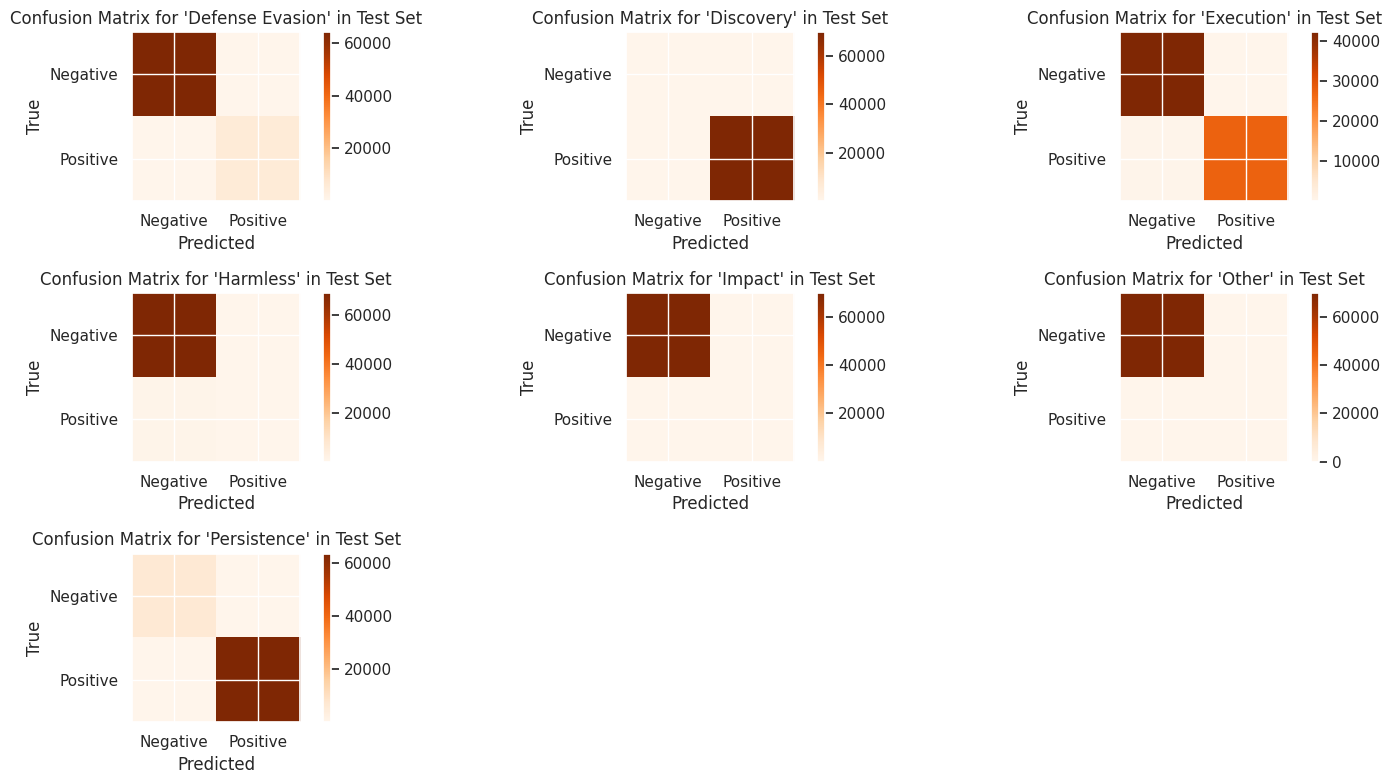

In [43]:
# Plotting the confusion matrix
plt.figure(figsize=(15, 8))
for i, label in enumerate(mlb.classes_):
    plt.subplot(3, 3, i + 1)
    plt.title(f"Confusion Matrix for '{label}' in Test Set")
    plt.imshow(confusion_rf_test[i], cmap='Oranges', interpolation='nearest')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(np.arange(2), ['Negative', 'Positive'])
    plt.yticks(np.arange(2), ['Negative', 'Positive'])

plt.tight_layout()
plt.show()

<br>
<left><b><font size=4>K-Nearest Neighbors (KNN)<b><left>

<div style="text-align: justify">K-Nearest Neighbors (KNN) operates as a supervised learning classifier that relies on the concept of proximity to perform classifications or predictions for individual data points. Its fundamental principle is grounded in the notion that similar data points tend to cluster together. In the context of classification tasks, KNN assigns a class label to a data point by considering the majority vote of its nearest neighbors. Put simply, it selects the label that is most prevalent among the neighboring data points in close proximity to the one being evaluated.</div><br>

In [44]:
y_train_mlb
X_train

system        sh   busybox        cp        52     while       tmp  \
4699    0.000000  0.000000  0.000000  0.063164  0.000000  0.125796  0.128216   
113772  0.054569  0.000000  0.109705  0.088115  0.054251  0.000000  0.000000   
64201   0.054569  0.000000  0.109705  0.088115  0.054251  0.000000  0.000000   
221592  0.078287  0.117615  0.078694  0.000000  0.077831  0.000000  0.000000   
198673  0.071243  0.428134  0.071614  0.000000  0.070828  0.000000  0.000000   
...          ...       ...       ...       ...       ...       ...       ...   
119879  0.054569  0.000000  0.109705  0.088115  0.054251  0.000000  0.000000   
103694  0.078287  0.117615  0.078694  0.000000  0.077831  0.000000  0.000000   
131932  0.078287  0.117615  0.078694  0.000000  0.077831  0.000000  0.000000   
146867  0.078287  0.117615  0.078694  0.000000  0.077831  0.000000  0.000000   
121958  0.078287  0.117615  0.078694  0.000000  0.077831  0.000000  0.000000   

             var    base64    decode  ...        lh     which     model  \
4699    0.000000  0.000000  0.000000  ...  0.126712  0.125966  0.127564   
113772  0.054380  0.162961  0.054424  ...  0.000000  0.000000  0.000000   
64201   0.054380  0.162961  0.054424  ...  0.000000  0.000000  0.000000   
221592  0.078016  0.155860  0.078079  ...  0.000000  0.000000  0.000000   
198673  0.070997  0.141838  0.071054  ...  0.000000  0.000000  0.000000   
...          ...       ...       ...  ...       ...       ...       ...   
119879  0.054380  0.162961  0.054424  ...  0.000000  0.000000  0.000000   
103694  0.078016  0.155860  0.078079  ...  0.000000  0.000000  0.000000   
131932  0.078016  0.155860  0.078079  ...  0.000000  0.000000  0.000000   
146867  0.078016  0.155860  0.078079  ...  0.000000  0.000000  0.000000   
121958  0.078016  0.155860  0.078079  ...  0.000000  0.000000  0.000000   

           lscpu     sleep    passwd     admin       15s  \
4699    0.127953  0.000000  0.000000  0.000000  0.000000   
113772  0.000000  0.488070  0.054274  0.054994  0.434751   
64201   0.000000  0.488070  0.054274  0.054994  0.434751   
221592  0.000000  0.389004  0.077864  0.078897  0.311856   
198673  0.000000  0.354006  0.070859  0.071798  0.283799   
...          ...       ...       ...       ...       ...   
119879  0.000000  0.488070  0.054274  0.054994  0.434751   
103694  0.000000  0.389004  0.077864  0.078897  0.311856   
131932  0.000000  0.389004  0.077864  0.078897  0.311856   
146867  0.000000  0.389004  0.077864  0.078897  0.311856   
121958  0.000000  0.389004  0.077864  0.078897  0.311856   

        iyevymlul2jhc2gky2qgl3rtcakkcm0glxjmic5zc2gkcm0glxjmic5tb3vudgzzcnjtic1yziauwdezlxvuaxgkcm0glxjmic5ymtctdw5peapta2rpciauwde3lxvuaxgky2qgllgxny11bml4cm12ic92yxivdg1wl2rvdgeudgfylmd6igrvdgeudgfylmd6cnrhcib4zibkb3rhlnrhci5negpzbgvlccazcyamjibjzcavdg1wly5ymtctdw5pec8ucnn5bmmvywpub2h1ccavdg1wly5ymtctdw5pec8ucnn5bmmvyy90c20glxqgmtuwic1tidyglxmgniatccaymiatucawic1midaglwsgmsatbcaxic1pidagl3rtcc91cc50ehqgmtkylje2oca  \
4699                                             0.126899                                                                                                                                                                                                                                                                                                                                                                             
113772                                           0.000000                                                                                                                                                                                                                                                                                                                                                                             
64201                                            0.000000                                                                                                     

In [45]:
# Create the k-NN model
knn = KNeighborsClassifier()

st = time.time()
# Train the model on the training data
knn.fit(X_train, y_train_mlb)
et = time.time()

# get the execution time
elapsed_time = et - st
print(r'Time to train the model:', elapsed_time,'seconds')

Time to train the model: 0.07990360260009766 seconds


In [46]:
# Generate predictions on the test set
predictions_train = knn.predict(X_train) 

# Generate predictions on the test set
predictions_test = knn.predict(X_test)

In [47]:
# Evaluate the model's performance on the trainning data
accuracy = knn.score(X_test, y_test_mlb)
print(f"Accuracy of the k-NN model for the trainning set: {accuracy:.2f}")

# Evaluate the model's performance on the test data
accuracy = knn.score(X_test, y_test_mlb)
print(f"Accuracy of the k-NN model for the test set: {accuracy:.2f}")

Accuracy of the k-NN model for the trainning set: 0.98
Accuracy of the k-NN model for the test set: 0.98


<br>
<left><b><font size=3 >Classification Report<b><left>


##### Training Set

In [48]:
# Classification Report for trainning set
report_train_knn = classification_report(y_train_mlb, predictions_train, target_names=mlb.classes_, output_dict=True)
df_report_train = pd.DataFrame(report_train_knn).transpose()
print("Classification Report for Trainning set:")
df_report_train

Classification Report for Trainning set:


precision    recall  f1-score   support
Defense Evasion   0.993647  0.971268  0.982330   13365.0
Discovery         0.999545  0.999902  0.999723  162486.0
Execution         0.999226  0.989327  0.994252   65210.0
Harmless          0.910959  0.173177  0.291028    1536.0
Impact            0.833333  0.200000  0.322581      25.0
Other             1.000000  0.959821  0.979499     224.0
Persistence       0.999506  0.999520  0.999513  147864.0
micro avg         0.999210  0.993688  0.996442  390710.0
macro avg         0.962317  0.756145  0.795561  390710.0
weighted avg      0.998917  0.993688  0.995294  390710.0
samples avg       0.999000  0.994489  0.996089  390710.0

##### Validation Set

In [49]:
# Classification Report for test set
report_test_knn = classification_report(y_test_mlb, predictions_test, target_names=mlb.classes_, output_dict=True)
df_report_test_knn = pd.DataFrame(report_test_knn).transpose()
print("Classification Report for Test set:")
df_report_test_knn

Classification Report for Test set:


precision    recall  f1-score   support
Defense Evasion   0.991991  0.967341  0.979511    5634.0
Discovery         0.999412  0.999871  0.999641   69659.0
Execution         0.999015  0.988022  0.993488   27717.0
Harmless          0.922414  0.159701  0.272265     670.0
Impact            1.000000  0.500000  0.666667       2.0
Other             1.000000  0.922330  0.959596     103.0
Persistence       0.999338  0.999464  0.999401   63431.0
micro avg         0.999020  0.993236  0.996120  167216.0
macro avg         0.987453  0.790961  0.838653  167216.0
weighted avg      0.998760  0.993236  0.994909  167216.0
samples avg       0.998816  0.994102  0.995735  167216.0

<br>
<left><b><font size=3> Confusion Matrix <b><left>

The code presented below prints a series of confusion matrices for each class, displaying True-Positive (top-left), False-Negative (bottom-left), False-Positive (top-right), and True-Negative (bottom-right) counts.
- True Positives (TP): Predicted correctly as positive.
- False Positives (FP): Predicted as positive but actually negative.
- False Negatives (FN): Predicted as negative but actually positive.
- True Negatives (TN): Predicted correctly as negative.

Each value in the confusion matrix represents the count of instances falling into these categories for a specific label.

In [50]:
# Evaluate with a confusion matrix and classification report
confusion_knn_test = multilabel_confusion_matrix(y_test_mlb, predictions_test)
# Printing the confusion matrix
for i, label in enumerate(mlb.classes_):
    print(f"Confusion Matrix for {label}:")
    print(confusion_knn_test[i])
    print()

Confusion Matrix for Defense Evasion:
[[64233    44]
 [  184  5450]]

Confusion Matrix for Discovery:
[[  211    41]
 [    9 69650]]

Confusion Matrix for Execution:
[[42167    27]
 [  332 27385]]

Confusion Matrix for Harmless:
[[69232     9]
 [  563   107]]

Confusion Matrix for Impact:
[[69909     0]
 [    1     1]]

Confusion Matrix for Other:
[[69808     0]
 [    8    95]]

Confusion Matrix for Persistence:
[[ 6438    42]
 [   34 63397]]



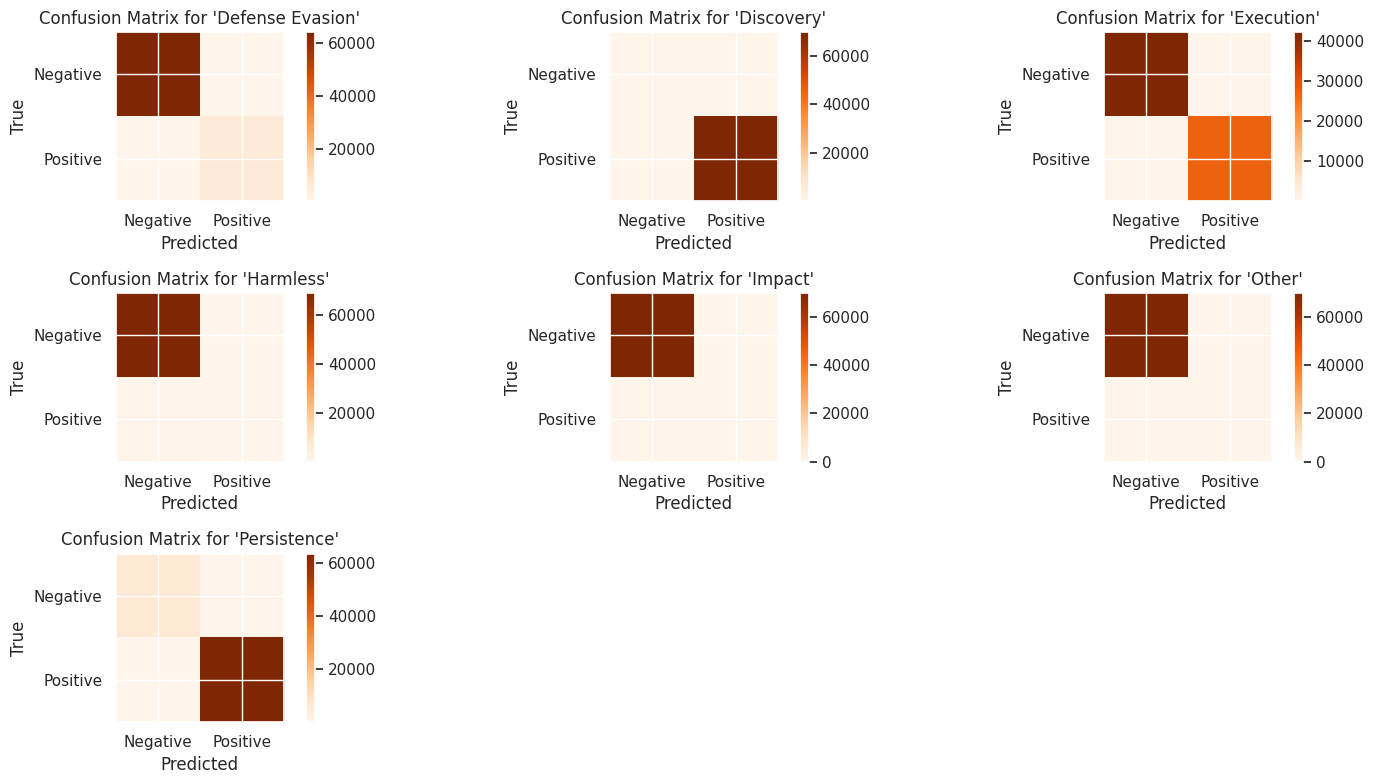

In [51]:
# Plotting the confusion matrix
plt.figure(figsize=(15, 8))
for i, label in enumerate(mlb.classes_):
    plt.subplot(3, 3, i + 1)
    plt.title(f"Confusion Matrix for '{label}'")
    plt.imshow(confusion_knn_test[i], cmap='Oranges', interpolation='nearest')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(np.arange(2), ['Negative', 'Positive'])
    plt.yticks(np.arange(2), ['Negative', 'Positive'])

plt.tight_layout()
plt.show()

<div style="text-align: justify"> To know whether the model is underfitting or overfitting, we must first define these two terms. <br>
<div style="text-align: justify"><br><b>Underfitting</b> occurs when a model is too simple to capture the underlying patterns in the training data, resulting in poor performance even on the training set.  One indicator used to identify this modelling error is to look at the results; if both training and validation/testing performance are poor, the model is considered to be underfitted.</div><br>

<div style="text-align: justify"><b>Overfitting</b> occurs when a model not only learns the underlying patterns in the training data, but also captures noise and random fluctuations, causing it to perform poorly on new and unknown data. One indicator used to identify this modelling error is to look at the results, if the model performs well on training data but poorly on validation or test data, it is considered overfitted.</div><br>

<div style="text-align: justify">Once these two terms have been defined, it is possible to move on to the results obtained for both models. It is important to mention that, for both tests performed with the different classifiers, the default parameters were used.</div><br>
<div style="text-align: justify">For the <b>Random Forest (RF)</b> case, the default parameter implied the number of estimators equal to 100, and the tree depth was set to <i>'None'</i>. On the other hand, for the <b>K-Nearest Neighbor (KNN)</b> classifier, the number of estimators was set to 5, the leaf size to 30 and the type of distance calculation was <i>'Euclidean distance'</i> (p=2), all default parameters of the classifier.</div><br>
    
<b> Random Forest (RF)</b>
<div style="text-align: justify"> In the classification report of the training and test sets, for most of the classes, accuracy, recall and F1 score are slightly lower in the test set compared to the training set. This was expected, as models tend to generalise slightly worse with unseen data. However, the drop in performance is not significant, which indicates that the model still performs well on the test set. Furthermore, the accuracy obtained for the training set was 99%, while 98% for the test set.<br><br>
    
<div style="text-align: justify">As can be seen in the validation set report, the model was not able to correctly classify instances of the <i>'Impact'</i> class, performing very poorly (0%) on all precision, recall and F1 score metrics. This result could be due to the default parameters set to train the model.  Tree depth is one of the most important parameter for tuning the model, as it sets the stop condition that limits the number of splits or levels deep a decision tree can go.</div><br>

<div style="text-align: justify">To enhance the classifier results, it is necessary to adjust the maximum depth of the decision trees when performing hyperparameter fitting for a random forest model. The <i>'weighted avg'</i> metric also showed a decrease in performance on the test set, indicating that the model does not perform as well on the test set across all classes, considering the distribution of classes. Overall, the performance metrics on the test set remain high, indicating that the overfitting is not critical. </div><br>

<b> K-Nearest Neighbor (KNN)</b>

<div style="text-align: justify">On the other hand, the classification report obtained for the KNN classifier showed a small difference between the training set and the validation set, for the test set the values obtained for each of the metrics; accuracy, recall, f1-score, were slightly lower compared to the results obtained for the training set.</div><br>

<div style="text-align: justify"> For the <i>'Impact'</i> class, the metrics derived in the training set were significantly lower compared to the validation set, for all metrics. This improvement in the accuracy, recall and f1-score parameters for the <i>'Impact'</i> class in the test set indicates that the model's predictions for this class are more accurate and reliable when evaluated with new, unseen data.  Producing a recall of 50%, which means, that the model only correctly predicted this class for 50% of the evaluated intents. </div><br>

<div style="text-align: justify">The difference obtained in this class for the training and validation sets suggests that the model did not sufficiently fit the <i>'Impact'</i> class during training, and then after the selection of the nearest neighbour from the test set, the model adjusted its predictions to better capture the features of the <i>'Impact'</i> class. However, it is important to note that the KNN classifier does not fit the data, it does not learn from the model, it only calculates the distance to the nearest points and selects the class according to the majority result of the nearest neighbours.</div><br>

<div style="text-align: justify"> In general, the observed results do not indicate underfitting or overfitting, in fact, the average accuracy obtained in the classification report was 99%, matching with the obtained in the calculated accuracy score (98% for both sets). The high values of the <i>'micro-average'</i> in both sets suggest a good overall performance of the model. While the <i>'macro-average'</i> values are higher only in the test set, indicating that the model performs better after calculating the Euclidean distance of each point.</div><br>


**2.3 Tune the hyper-parameters of the models through cross-validation. How do performance vary?**

#### K-Fold Cross-Validation

For this experiment, a value of 5 K-fold cross-validation was selected.

In [52]:
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import make_scorer, f1_score, precision_score

scorer = make_scorer(f1_score, average='macro')
kf = KFold(n_splits=5)
kf.get_n_splits(X_train)

for i, (train_index,test_index) in enumerate(kf.split(X_train)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[ 32625  32626  32627 ... 163121 163122 163123]
  Test:  index=[    0     1     2 ... 32622 32623 32624]
Fold 1:
  Train: index=[     0      1      2 ... 163121 163122 163123]
  Test:  index=[32625 32626 32627 ... 65247 65248 65249]
Fold 2:
  Train: index=[     0      1      2 ... 163121 163122 163123]
  Test:  index=[65250 65251 65252 ... 97872 97873 97874]
Fold 3:
  Train: index=[     0      1      2 ... 163121 163122 163123]
  Test:  index=[ 97875  97876  97877 ... 130497 130498 130499]
Fold 4:
  Train: index=[     0      1      2 ... 130497 130498 130499]
  Test:  index=[130500 130501 130502 ... 163121 163122 163123]


##### Random Forest 

In [53]:
cross_val_score(model_rf, X_train, y_train_mlb, cv=kf, scoring = scorer)

array([0.74417281, 0.75214238, 0.75010576, 0.75572704, 0.74616319])

##### K-Nearest Neighbor

In [54]:
cross_val_score(knn, X_train, y_train_mlb, cv=kf, scoring=scorer)

array([0.76952972, 0.7844786 , 0.74965243, 0.75537561, 0.74437104])

#### Grid Search Technique

<div style="text-align: justify">Hyperparameters are settings that control the learning process of machine learning models. While the parameters are learned during the training process, the hyperparameters are set before the training starts. Therefore, in order to find the parameters that best fit the performance of the model, the GridSearch technique was applied. This technique applies all possible combinations of hyperparameters, resulting in a set of parameters that will improve the performance of the model.</div>

#### Random Forest

In [25]:
#GRID SEARCH
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
params = {'n_estimators': [10, 50, 80], 'max_depth': [15, 25, 50] } #'criterion' :['gini', 'entropy']}

# Instantiate the grid search model
gs_rf = GridSearchCV(model_rf, param_grid = params, scoring='f1_macro', cv = 5, verbose = 1) 
# scoring='accuracy'
# cv: that's the number of fold for the cross-validation
# verbose: specifies the verbosity level of the GridSearchCV object. 

# Trainning the model
st = time.time()
gs_rf.fit(X_train, y_train_mlb)
et = time.time()

# get the execution time
elapsed_time = et - st
print(r'Time used by Grid Search:', elapsed_time,'seconds')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Time used by Grid Search: 297.79476404190063 seconds


In [26]:
best_params_rf = gs_rf.best_params_
print(r'The best combination of parameters the Grid Search has found is:', best_params_rf)
print("Best F1-Score: {:.2f}".format(gs_rf.best_score_))

The best combination of parameters the Grid Search has found is: {'max_depth': 50, 'n_estimators': 10}
Best F1-Score: 0.77


#### Ask to the prof which graph we should use -------------------------------------------------------------------------

In [57]:
# Bar plot

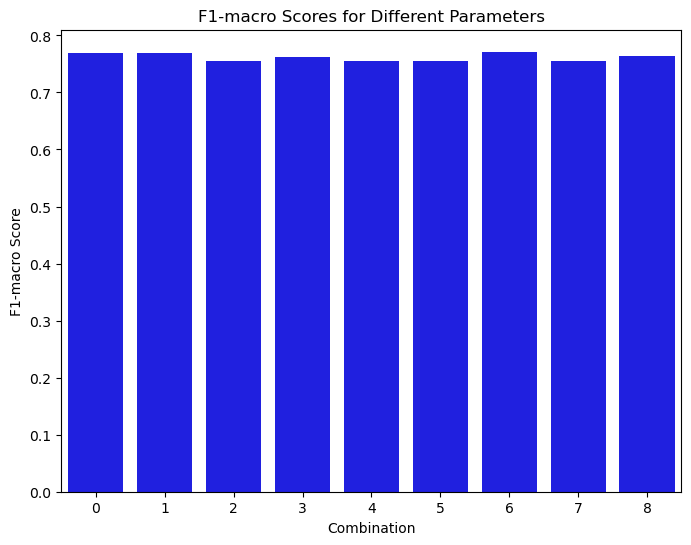

In [27]:
# Let's print the f1 macro reached for each combination
y = gs_rf.cv_results_["mean_test_score"].tolist()
x = [i for i in range (1, len(y)+1)]
mean_test_score_df = pd.DataFrame()
mean_test_score_df["f1_macro"] = y

plt.figure(figsize=(8, 6))
sns.barplot(x = mean_test_score_df.index, y = "f1_macro", data = mean_test_score_df, color='blue')

# Add a title and labels to the plot
plt.title('F1-macro Scores for Different Parameters')
plt.xlabel('Combination')
plt.ylabel('F1-macro Score')
plt.show()

In [ ]:
# Heatmap plot

In [ ]:
results_rf = pd.DataFrame(gs_rf.cv_results_)
results_rf

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       1.193431      0.024694         0.167718        0.005687   
1       5.585006      0.082768         0.643154        0.022999   
2       8.791338      0.115788         1.017184        0.056646   
3       1.135275      0.005272         0.158494        0.003572   
4       5.359536      0.058700         0.640582        0.006807   
5       8.557390      0.057323         1.029486        0.034283   
6       1.158237      0.034479         0.164057        0.001741   
7       5.416170      0.072332         0.608022        0.020933   
8       8.830967      0.125213         1.070908        0.022634   

  param_max_depth param_n_estimators                                 params  \
0              15                 10  {'max_depth': 15, 'n_estimators': 10}   
1              15                 50  {'max_depth': 15, 'n_estimators': 50}   
2              15                 80  {'max_depth': 15, 'n_estimators': 80}   
3              25                 10  {'max_depth': 25, 'n_estimators': 10}   
4              25                 50  {'max_depth': 25, 'n_estimators': 50}   
5              25                 80  {'max_depth': 25, 'n_estimators': 80}   
6              50                 10  {'max_depth': 50, 'n_estimators': 10}   
7              50                 50  {'max_depth': 50, 'n_estimators': 50}   
8              50                 80  {'max_depth': 50, 'n_estimators': 80}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0           0.772557           0.752076           0.751905           0.755844   
1           0.772693           0.752159           0.750066           0.755729   
2           0.744171           0.752165           0.750149           0.803349   
3           0.744180           0.752252           0.750075           0.812779   
4           0.772728           0.751923           0.750073           0.755862   
5           0.770061           0.752054           0.750096           0.755724   
6           0.744017           0.750142           0.749970           0.755678   
7           0.772643           0.752045           0.750168           0.755730   
8           0.770143           0.752050           0.750100           0.755731   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
0           0.746180         0.755712        0.008971                3  
1           0.746135         0.755356        0.009208                4  
2           0.746101         0.759187        0.022262                2  
3           0.746021         0.761061        0.026016                1  
4           0.746001         0.755317        0.009265                6  
5           0.746111         0.754809        0.008233                8  
6           0.746180         0.749197        0.003986                9  
7           0.746121         0.755341        0.009188                5  
8           0.746054         0.754816        0.008276                7

In [ ]:
# We create a pivot table 
scores_rf = results_rf.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')
scores_rf

param_n_estimators        10        50        80
param_max_depth                                 
15                  0.755712  0.755356  0.759187
25                  0.761061  0.755317  0.754809
50                  0.749197  0.755341  0.754816

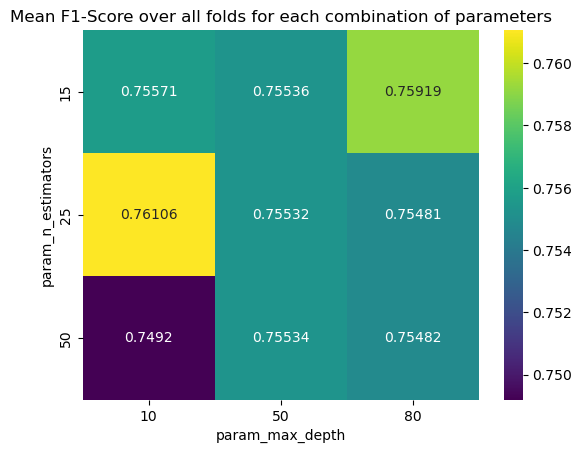

In [ ]:
sns.heatmap(scores_rf, annot=True, cmap='viridis', fmt='.5g')
plt.xlabel('param_max_depth')
plt.ylabel('param_n_estimators')
plt.title('Mean F1-Score over all folds for each combination of parameters')
plt.show()

#### K-Nearest Neighbor

In [ ]:
#GRID SEARCH tuning
from sklearn.model_selection import GridSearchCV

params = {'n_neighbors': [5, 7, 9], 'leaf_size': [5, 15, 20]} #'metric': ['euclidean', 'manhattan']} 
grid_search_knn = GridSearchCV(knn, params, scoring='f1_macro', cv = 5, verbose=1)
# scoring = 'accuracy'

st = time.time()
grid_search_knn.fit(X_train, y_train_mlb)
et = time.time()

# get the execution time
elapsed_time = et - st
print(r'Time used by Grid Search:', elapsed_time,'seconds')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Time used by Grid Search: 5646.74089884758 seconds


In [ ]:
best_params_knn = grid_search_knn.best_params_
print(r'The best combination of parameters the Grid Search has found is:', best_params_knn)
print("Best F1-Score: {:.2f}".format(grid_search_knn.best_score_))

The best combination of parameters the Grid Search has found is: {'leaf_size': 5, 'n_neighbors': 5}
Best F1-Score: 0.76


#### Aks to the prof which graph we should use --------------------------------------------------------------------------

In [ ]:
#Bar plot

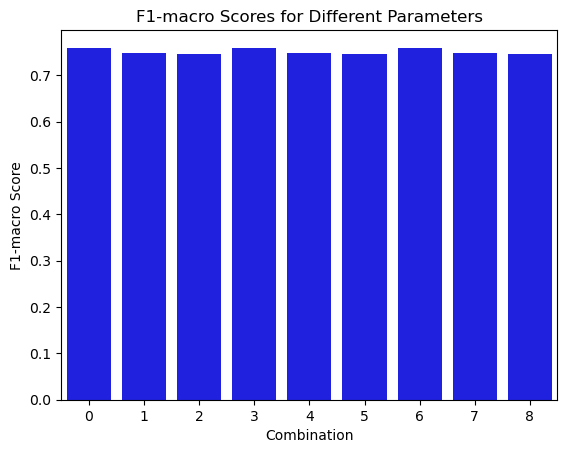

In [ ]:
# Let's print the f1 macro reached for each combination
y = grid_search_knn.cv_results_["mean_test_score"].tolist()
x = [i for i in range (1, len(y)+1)]
mean_test_score_df = pd.DataFrame()
mean_test_score_df["f1_macro"] = y
#print(mean_test_score_df)

sns.barplot(x = mean_test_score_df.index, y = "f1_macro", data = mean_test_score_df, color='blue')

# Add a title and labels to the plot
plt.title('F1-macro Scores for Different Parameters')
plt.xlabel('Combination')
plt.ylabel('F1-macro Score')

# Display the plot
plt.show()

In [ ]:
# Heatmap plot

In [ ]:
results_knn = pd.DataFrame(grid_search_knn.cv_results_)
results_knn

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.063751      0.005010       123.378629        1.516909   
1       0.061029      0.001861       123.884146        1.621348   
2       0.060939      0.002027       121.696665        2.384636   
3       0.060516      0.001651       120.890996        1.625508   
4       0.062210      0.002833       127.539321        4.308606   
5       0.064475      0.002505       129.376618        2.169754   
6       0.065911      0.002217       129.627259        2.311849   
7       0.063543      0.001081       126.340536        1.889811   
8       0.061999      0.003632       126.024147        1.808733   

  param_leaf_size param_n_neighbors                               params  \
0               5                 5   {'leaf_size': 5, 'n_neighbors': 5}   
1               5                 7   {'leaf_size': 5, 'n_neighbors': 7}   
2               5                 9   {'leaf_size': 5, 'n_neighbors': 9}   
3              15                 5  {'leaf_size': 15, 'n_neighbors': 5}   
4              15                 7  {'leaf_size': 15, 'n_neighbors': 7}   
5              15                 9  {'leaf_size': 15, 'n_neighbors': 9}   
6              20                 5  {'leaf_size': 20, 'n_neighbors': 5}   
7              20                 7  {'leaf_size': 20, 'n_neighbors': 7}   
8              20                 9  {'leaf_size': 20, 'n_neighbors': 9}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0           0.770082           0.779738           0.749393           0.755222   
1           0.741482           0.748731           0.749284           0.754629   
2           0.737189           0.748661           0.748302           0.754751   
3           0.770082           0.779738           0.749393           0.755222   
4           0.741482           0.748731           0.749284           0.754629   
5           0.737189           0.748661           0.748302           0.754751   
6           0.770082           0.779738           0.749393           0.755222   
7           0.741482           0.748731           0.749284           0.754629   
8           0.737189           0.748661           0.748302           0.754751   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
0           0.744279         0.759743        0.013216                1  
1           0.744331         0.747691        0.004507                4  
2           0.744258         0.746632        0.005790                7  
3           0.744279         0.759743        0.013216                1  
4           0.744331         0.747691        0.004507                4  
5           0.744258         0.746632        0.005790                7  
6           0.744279         0.759743        0.013216                1  
7           0.744331         0.747691        0.004507                4  
8           0.744258         0.746632        0.005790                7

In [ ]:
# We create a pivot table before create the heatmap
scores_knn = results_knn.pivot(index='param_leaf_size', columns='param_n_neighbors', values='mean_test_score')
scores_knn

param_n_neighbors         5         7         9
param_leaf_size                                
5                  0.759743  0.747691  0.746632
15                 0.759743  0.747691  0.746632
20                 0.759743  0.747691  0.746632

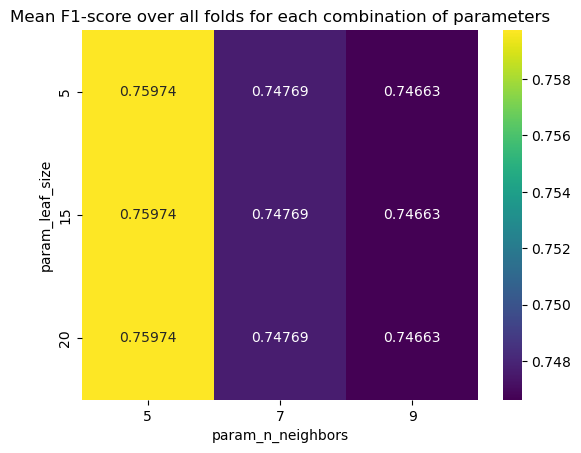

In [ ]:
sns.heatmap(scores_knn, annot=True, cmap='viridis', fmt='.5g')
plt.xlabel('param_n_neighbors')
plt.ylabel('param_leaf_size')
plt.title('Mean F1-score over all folds for each combination of parameters')
plt.show()

**2.4. Comments on the results for each on the intents.**

<div style="text-align: justify">The aim of this analysis is to assess the predictive capability of two models in classifying attack labels. The models will be evaluated based on the hyperparameters identified previously.</div>

##### Evaluation of Random Forest with tuned parameters

In [ ]:
# Random Forest with the hyperparameters
model_rf_tunned = RandomForestClassifier(n_estimators = 25, max_depth = 10) # (n_estimators=30, max_depth=50)

st = time.time()
# Trainning the model
model_rf_tunned.fit(X_train, y_train_mlb)
et = time.time()
# get the execution time
elapsed_time = et - st
print(f'Time to train the model:', elapsed_time,'seconds','\n')

# Predictions on test set
y_test_pred_tune = model_rf.predict(X_test)

# Evaluate the model's performance on the test data
accuracy = metrics.accuracy_score(y_test_mlb, y_test_pred_tune)
print(f"Accuracy of the 'Random Forest' model for test set: {accuracy:.2f}",'\n')

# Evaluate performance on test set
report_test_tune = classification_report(y_test_mlb, y_test_pred_tune, target_names=mlb.classes_, output_dict=True)
df_report_test_tune = pd.DataFrame(report_test_tune).transpose()
print(f'         Classification Report Trainning Set', '\n')
print(df_report_test_tune)

Time to train the model: 3.407459020614624 seconds 

Accuracy of the 'Random Forest' model for test set: 0.98 

         Classification Report Trainning Set 

                 precision    recall  f1-score   support
Defense Evasion   0.993802  0.967696  0.980576    5634.0
Discovery         0.999770  0.999627  0.999699   69659.0
Execution         0.999416  0.987697  0.993522   27717.0
Harmless          0.938053  0.158209  0.270754     670.0
Impact            0.000000  0.000000  0.000000       2.0
Other             1.000000  0.941748  0.970000     103.0
Persistence       0.999464  0.999527  0.999496   63431.0
micro avg         0.999350  0.993117  0.996224  167216.0
macro avg         0.847215  0.722072  0.744864  167216.0
weighted avg      0.999135  0.993117  0.995002  167216.0
samples avg       0.998751  0.993832  0.995593  167216.0


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


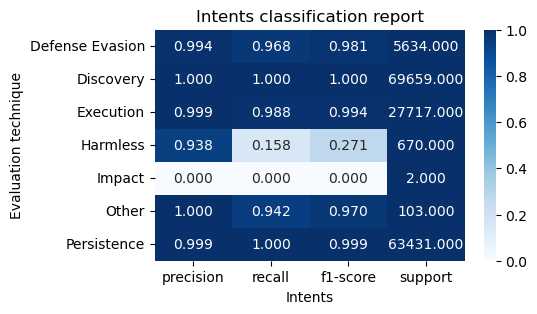

In [ ]:
# Compute the heatmap of the correlation matrix
plt.figure(figsize=(5, 3))
sns.heatmap(df_report_test_tune.loc["Defense Evasion" : "Persistence"], cmap='Blues', annot=True, vmin=.0, vmax=1,fmt='.3f')
plt.xlabel('Intents')
plt.ylabel('Evaluation technique')
plt.title('Intents classification report')
plt.show()

##### Evalutaing of K-Nearest Neighbors with tuned parameters 

In [ ]:
# Create the k-NN model
knn_tune = KNeighborsClassifier(leaf_size=5, n_neighbors=5)

# Train the model on the training data
t = time.time()
knn_tune.fit(X_train, y_train_mlb)
et = time.time()

# get the execution time
elapsed_time = et - st
print(r'Time to train the model:', elapsed_time,'seconds','\n')

# Generate predictions on the test set
predictions_knn_tune = knn.predict(X_test)

# Evaluate the model's performance on the test data
accuracy_knn_tune = knn.score(X_test, y_test_mlb)
print(f"Accuracy of the k-NN model: {accuracy_knn_tune:.2f}",'\n')

report_knn_tune = classification_report(y_test_mlb, predictions_knn_tune, target_names = mlb.classes_, output_dict=True)
df_report_knn_tune = pd.DataFrame(report_knn_tune).transpose()
print("              Classification Report for KNN",'\n')
print(df_report_knn_tune)

Time to train the model: 6224.603639364243 seconds 

Accuracy of the k-NN model: 0.98 

              Classification Report for KNN 

                 precision    recall  f1-score   support
Defense Evasion   0.992353  0.967341  0.979687    5634.0
Discovery         0.999655  0.999684  0.999670   69659.0
Execution         0.998505  0.988274  0.993364   27717.0
Harmless          0.922414  0.159701  0.272265     670.0
Impact            1.000000  0.500000  0.666667       2.0
Other             1.000000  0.922330  0.959596     103.0
Persistence       0.999354  0.999464  0.999409   63431.0
micro avg         0.999056  0.993200  0.996119  167216.0
macro avg         0.987469  0.790971  0.838665  167216.0
weighted avg      0.998795  0.993200  0.994909  167216.0
samples avg       0.998837  0.994022  0.995694  167216.0


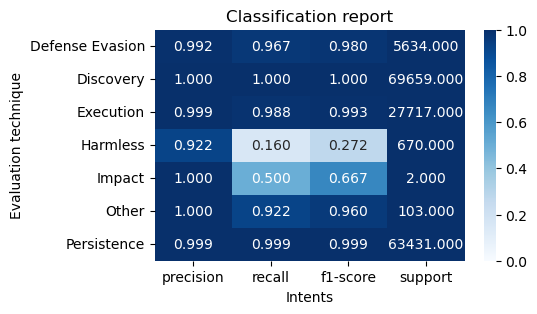

In [ ]:
# Compute the heatmap of the correlation matrix
plt.figure(figsize=(5, 3))
sns.heatmap(df_report_knn_tune.loc["Defense Evasion" : "Persistence"], cmap='Blues', annot=True, vmin=.0, vmax=1,fmt='.3f')
plt.xlabel('Intents')
plt.ylabel('Evaluation technique')
plt.title('Classification report')
plt.show()

Need to write how the hyperparameter tunning improves the result; especially in the intent Impact, for both models... I'll do it later.

**2.5 Explore the possible features: try combining features differently, e.g., does tf-idf improve or worsen performance? Think about the problem and summarize the ways you have tried (even those that did not work).**

<div style="text-align: justify"><b>First Attempt</b></div><br>

<div style="text-align: justify">For the first attempt, 33 features were used for the training set. The classifiers selected to perform the predictions were 'Random Forest' and 'K-Nearest Neighbor' with both models using the default parameters. In the performance evaluation, an accuracy of 98% was obtained for both models in the validation set.  While in the training set it reached 99% for RF and 98% for KNN. The decrease in accuracy achieved by RF in the validation set suggests a slight overfitting, however, it is a tolerable value that assumes that the model still performs well on the test set.</div><br>

<div style="text-align: justify">According to the classification report, for almost all attempts the values of precision, recall and f1-scores reached high percentages, around 98.9%.  Except for the 'Impact' and 'Harmless' intents when applying RF as a model, the results obtained for these classes were quite lower compared to those obtained for the other classes, both in the training set and in the validation set, where 0% was obtained in each metric. The model presented a very poor performance when trying to classify these two classes.</div><br>

<div style="text-align: justify">As for tuning techniques, K-fold cross-correlation and Grid Search were applied to see if the results obtained previously could be improved. However, when looking at the results obtained with 5 folds, the performance decreased considerably reaching an average of 77% accuracy. Suggests that the model may be in overfitting. </div><br>

<div style="text-align: justify">Therefore, for the next attempt we consider a reduction of the dimensionality of the data set to improve generalization.</div><br>

<div style="text-align: justify"><b>Second attempt</b></div><br>
<div style="text-align: justify">For the second attempt, the number of features was reduced to only 12 for the training set.  The classifiers used in the previous attempt, RF and KNN, were kept for this evaluation with both using their default parameters. The results obtained in the performance evaluation, the accuracy did not change from the previous attempt, reaching 98% for the RF case and 98% for the KNN for both the training and validation sets, indicating that the models continue to make good predictions for the classes.<br>
<br>
<div style="text-align: justify">If we take a look at the classification report for almost all attempts, the values for accuracy, recall and f1-scores reached high percentages, around 98%. Nevertheless, the performance of the 'Impact' class was very poor in both models for the classification obtained in the validation data, with 0% for every metric (precision, recall and f1-score), indicating that the number of features selected to train both models was not sufficient to be able to correctly classify this class.<br><br>
<div style="text-align: justify">In both training and validation reports, the F1 score obtained for the classes "Impact" and "Harmless" was very low compared to the other classes. It seems that for both models, these two classes are the most difficult to classify correctly. This could be due to the fact that, the number of data selected during the splitting of the training set did not cover enough samples of these two classes, as they are the least sampled attempts of the whole dataset. </div><br>

<div style="text-align: justify">After conducting multiple tests and adjusting the number of features in the training set, the results showed similar levels of accuracy. However, upon further analysis of the classification report parameters, it was found that the highest metrics for accuracy, recall, and F1-score were achieved with a number of features greater than 22. The F1-score parameter indicated that the models performed better in classifying samples belonging to the 'Impact' and 'Harmless' classes, which were more difficult to detect in almost all the tests. </div><br>

### <left><b><font size=4>Section 3 – Unsupervised Learning – Clustering<b><left>

<div style="text-align: justify">Cluster the attacks according to their characteristics. Choose at least 2 Clustering Algorithms, and for each of them solve the following points.</div>

In [55]:
df_exploded = result_df_corr.explode("Set_Fingerprint").reset_index()
df_exploded = df_exploded.drop(columns=['index'])
#features_exploted = result_df_exploded.drop(columns=["session_id", "full_session", "first_timestamp", "Set_Fingerprint", "bag_of_words", "tfid"])

# We should use the stardardized data (X and y features)
labels = df_exploded["Set_Fingerprint"]
result_df_exploded = df_exploded.filter(features_names)
result_df_exploded

system        sh   busybox        cp        52     while       tmp  \
0       0.000000  0.000000  0.000000  0.063164  0.000000  0.125796  0.128216   
1       0.000000  0.000000  0.000000  0.063164  0.000000  0.125796  0.128216   
2       0.000000  0.000000  0.000000  0.063164  0.000000  0.125796  0.128216   
3       0.000000  0.000000  0.000000  0.063164  0.000000  0.125796  0.128216   
4       0.000000  0.000000  0.000000  0.063164  0.000000  0.125796  0.128216   
...          ...       ...       ...       ...       ...       ...       ...   
557921  0.078287  0.117615  0.078694  0.000000  0.077831  0.000000  0.000000   
557922  0.078287  0.117615  0.078694  0.000000  0.077831  0.000000  0.000000   
557923  0.078287  0.117615  0.078694  0.000000  0.077831  0.000000  0.000000   
557924  0.078287  0.117615  0.078694  0.000000  0.077831  0.000000  0.000000   
557925  0.078287  0.117615  0.078694  0.000000  0.077831  0.000000  0.000000   

             var   base64    decode  ...        lh     which     model  \
0       0.000000  0.00000  0.000000  ...  0.126712  0.125966  0.127564   
1       0.000000  0.00000  0.000000  ...  0.126712  0.125966  0.127564   
2       0.000000  0.00000  0.000000  ...  0.126712  0.125966  0.127564   
3       0.000000  0.00000  0.000000  ...  0.126712  0.125966  0.127564   
4       0.000000  0.00000  0.000000  ...  0.126712  0.125966  0.127564   
...          ...      ...       ...  ...       ...       ...       ...   
557921  0.078016  0.15586  0.078079  ...  0.000000  0.000000  0.000000   
557922  0.078016  0.15586  0.078079  ...  0.000000  0.000000  0.000000   
557923  0.078016  0.15586  0.078079  ...  0.000000  0.000000  0.000000   
557924  0.078016  0.15586  0.078079  ...  0.000000  0.000000  0.000000   
557925  0.078016  0.15586  0.078079  ...  0.000000  0.000000  0.000000   

           lscpu     sleep    passwd     admin       15s  \
0       0.127953  0.000000  0.000000  0.000000  0.000000   
1       0.127953  0.000000  0.000000  0.000000  0.000000   
2       0.127953  0.000000  0.000000  0.000000  0.000000   
3       0.127953  0.000000  0.000000  0.000000  0.000000   
4       0.127953  0.000000  0.000000  0.000000  0.000000   
...          ...       ...       ...       ...       ...   
557921  0.000000  0.389004  0.077864  0.078897  0.311856   
557922  0.000000  0.389004  0.077864  0.078897  0.311856   
557923  0.000000  0.389004  0.077864  0.078897  0.311856   
557924  0.000000  0.389004  0.077864  0.078897  0.311856   
557925  0.000000  0.389004  0.077864  0.078897  0.311856   

        iyevymlul2jhc2gky2qgl3rtcakkcm0glxjmic5zc2gkcm0glxjmic5tb3vudgzzcnjtic1yziauwdezlxvuaxgkcm0glxjmic5ymtctdw5peapta2rpciauwde3lxvuaxgky2qgllgxny11bml4cm12ic92yxivdg1wl2rvdgeudgfylmd6igrvdgeudgfylmd6cnrhcib4zibkb3rhlnrhci5negpzbgvlccazcyamjibjzcavdg1wly5ymtctdw5pec8ucnn5bmmvywpub2h1ccavdg1wly5ymtctdw5pec8ucnn5bmmvyy90c20glxqgmtuwic1tidyglxmgniatccaymiatucawic1midaglwsgmsatbcaxic1pidagl3rtcc91cc50ehqgmtkylje2oca  \
0                                                0.126899                                                                                                                                                                                                                                                                                                                                                                             
1                                                0.126899                                                                                                                                                                                                                                                                                                                                                                             
2                                                0.126899                                                                                                                 

<div style="text-align: justify"> Two clustering algorithms will be implemented to our dataset, the chosen were MiniBatchK-Means and Gaussian Mixture Model (GMM). <br>
First of all we have to select the features to be evaluate, <b>'Pricipal Component Analysis (PCA)'</b> was used to reduce the dimensionality of the data.</div>

#### Dimensionality Reduction by applying 'PCA'

In [70]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA

# Reduce dimensionality using PCA----------------------------------------
pca = PCA(n_components=10)        # Adjust the number of components as needed
reduced_data = pca.fit_transform(result_df_exploded)

#### K-Means

In [114]:
# k-Means with n_clusters = 3
# cl_labels3 = kmeans.fit_predict(features_exploted) # Get clusters ID
kmeans = KMeans(n_clusters=3)
cl_labels3 = kmeans.fit(reduced_data) # Using the features selected

# print the clustered labels
print('The clustered labels are:\n', kmeans.labels_)
print()

# print the centroid of each feature for each cluster
print('The centroids are:\n', kmeans.cluster_centers_)
print()

The clustered labels are:
 [2 2 2 ... 1 1 1]

The centroids are:
 [[-1.78197832e-01  9.38524062e-02  3.95355119e-03 -6.13636207e-04
  -3.64098724e-05  5.25869832e-04 -1.63002476e-04  6.47523744e-04
   4.13208284e-05 -2.65726000e-04]
 [ 1.06930175e-01 -1.65220962e-01 -6.60469945e-04  1.10447579e-03
  -3.28301599e-04 -7.41223004e-04 -5.39947138e-06 -3.92616836e-04
  -2.90660525e-04  1.88301911e-04]
 [ 5.71968128e-01  3.96413606e-01 -2.36566943e-02 -2.74696755e-03
   2.35998874e-03  1.03899670e-03  1.18438606e-03 -2.05236596e-03
   1.57055208e-03  6.68097385e-04]]



In [115]:
# Unsupervised metric  (it takes approx 2500 sec o 3000 sec)
silhouette  = silhouette_score(reduced_data, kmeans.labels_)

# Supervised metrics
ri = rand_score(np.ravel(labels), kmeans.labels_)
ari = adjusted_rand_score(np.ravel(labels), kmeans.labels_)

In [116]:
print('k-Means with 3 clusters')
(unique, counts)=np.unique(kmeans.labels_, return_counts=True)
print("Size of each cluster: ", counts)
print(f'k_means clustering error: {round(kmeans.inertia_, 2)}')
print(f'Silhouette: {round(silhouette, 2)}')
print(f'RI: {round(ri, 2)}')
print(f'ARI: {round(ari, 2)}')

k-Means with 3 clusters
Size of each cluster:  [272166 247176  38584]
k_means clustering error: 5669.2
Silhouette: 0.91
RI: 0.57
ARI: 0.1


#### Gaussian mixture model (GMM)

In [117]:
gmm = GaussianMixture(n_components=3)
gmm.fit(result_df_exploded)           # Get clusters ID

GaussianMixture(n_components=3)

In [118]:
# print the clustered labels
gmm_labels = gmm.predict(result_df_exploded)
print('The clustered labels are:\n', gmm_labels)

The clustered labels are:
 [2 2 2 ... 0 0 0]


In [ ]:
# Unsupervised metric
silhouette  = silhouette_score(result_df_exploded, gmm_labels)
log_l = gmm.score(result_df_exploded)

# Supervised metrics
ri = rand_score(np.ravel(labels), gmm_labels)
ari = adjusted_rand_score(np.ravel(labels), gmm_labels)

In [ ]:
# report effective size
print("Effetive size of each cluster: ", gmm.weights_)
# report usupervised and supervised metric
print(f'GMM total log-likelihood score: {round(log_l, 2)}')
print(f'Silhouette: {round(silhouette, 2)}')
print(f'RI: {round(ri, 2)}')
print(f'ARI: {round(ari, 2)}')

**3.1. Determine the number of clusters: This can be done using methods like the elbow method or
silhouette analysis. Explain your reasoning.**

<div style="text-align: justify"> The clustering error is strongly dependent form the number of cluster. 
The best situation, with the lowest error possible, is obiuously when we have the same number of clusters of the datapoins. Actually in this situation we're not even performing clustering, but the clustering error will be zero.<br>
<br>
Now we want to find the number of clusters that gives us the best results, so with the lowest clustering error. 
We'll follow 2 approches for each clustering algorithm applied, elbow method and validation error. </div>

#### K-Means

In [124]:
# Step 1: Elbow Method  (260 sec)
n_cluster_list=[]
inertia_list=[]
shs_list = []
ri_list = []
ari_list = []

for n_clusters in range(3, 16):
    kmeans_new = KMeans(n_clusters=n_clusters)
    cl_labels = kmeans_new.fit_predict(reduced_data)
    
    # Unsupervised metric  (If we evaluate the silhoutte it takes too long)
    # silhouette = silhouette_score(reduced_data, cl_labels)
    # n_cluster_list.append(n_clusters)
    # shs_list.append(silhouette)
    
   # Rand Index and Adjusted Rand Index:
    ri_list.append(rand_score(np.ravel(labels), cl_labels))
    ari_list.append(adjusted_rand_score(np.ravel(labels), cl_labels))
    
    # For Elbow Method (Inertia):
    inertia_list.append(kmeans_new.inertia_)
    n_cluster_list.append(n_clusters)

**Elbow Method**

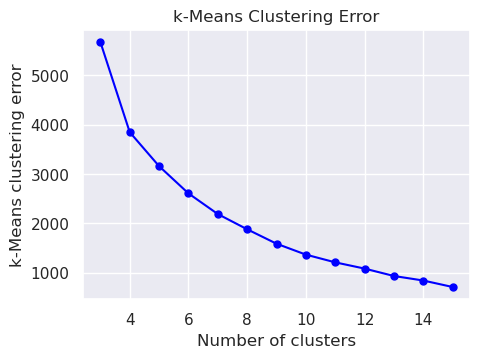

In [127]:
# Step 3
# Plot k-Means clustering error 
# Set up Seaborn style
sns.set(style="darkgrid")

plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, inertia_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('k-Means clustering error')
plt.title('k-Means Clustering Error Analysis')
plt.show()

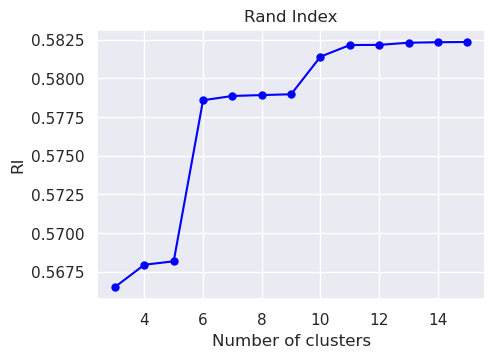

In [130]:
# Plot RI
# Set up Seaborn style
sns.set(style="darkgrid")

plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, ri_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('RI')
plt.title('Rand Index Analysis')
plt.show()

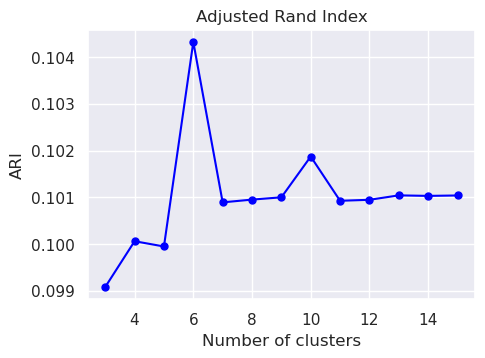

In [131]:
# Plot ARI
# Set up Seaborn style
sns.set(style="darkgrid")

plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, ari_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('ARI')
plt.title('Adjusted Rand Index')
plt.show()

**THE CODE BELOW: IT's used if we would have chosen to perform the silhouette analysis, but it is not mandatory, of course we have to justify why we do not choose this one, computational time and so on...**

In [ ]:
# Silhouette
# Get n_clusters leading to the highest silhouette
best_sh = np.max(shs_list)
best_n = n_cluster_list[np.argmax(shs_list)]
print("best k: ",best_n, " with corresponding silhouette: ", best_sh)

# Plot
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list,shs_list, marker='o', markersize=5)
plt.scatter(best_n, best_sh, color='r', marker='x', s=90)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

#### Gaussian Mixture Model (GMM)

In [ ]:
n_cluster_list=[]
shs_list = []
ri_list = []
ari_list = []
log_l_list=[]

for n_clusters in range(3, 16):
    gmm = GaussianMixture(n_components=n_clusters)
    cl_labels = gmm.fit_predict(X_s)
    
    # silhouette  = silhouette_score(X_s, cl_labels)
    # n_cluster_list.append(n_clusters)
    # shs_list.append(silhouette)
    
    ri_list.append(rand_score(np.ravel(y), cl_labels))
    ari_list.append(adjusted_rand_score(np.ravel(y), cl_labels))
    log_l_list.append(gmm.score(X_s))

**Elbow Method**

In [ ]:
#3. Has the performance improved also on the other metrics? Plot the other metrics for the different values of n_cluster.
# Set up Seaborn style
sns.set(style="darkgrid")

# Plot GMM total log-likelihood score
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list,log_l_list, marker='o', markersize=5)
plt.xlabel('Number of clusters')
plt.ylabel('GMM total log-likelihood score')
plt.show()

# Plot ARI
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list,ari_list, marker='o', markersize=5)
plt.xlabel('Number of clusters')
plt.ylabel('ARI')
plt.show()

In [ ]:
#2. Plot the silhouette score for the different values of n_cluster. 
# What is the best value of k, leading to the highest Silhouette.

# Get n_clusters leading to the highest silhouette
best_sh= np.max(shs_list)
best_n=n_cluster_list[np.argmax(shs_list)]
print("best k: ",best_n, " with corresponding silhouette: ", best_sh)

# Plot
# Set up Seaborn style
sns.set(style="darkgrid")
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list,shs_list, marker='o', markersize=5)
plt.scatter(best_n, best_sh, color='r', marker='x', s=90)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

**3.2. Tune other hyper-parameters, if any.**

##### Tunning the hyperparameter of K-Means

In [139]:
# Step 1: Elbow Method
n_cluster_list=[]
inertia_list=[]
shs_list = []
ri_list = []
ari_list = []

for n_clusters in range(3, 16):
    kmeans_tunning = KMeans(n_clusters=n_clusters, init='k-means++', random_state=None, n_init=1)
    labels_tunning = kmeans_tunning.fit_predict(reduced_data) # Using the features selected
    # kmeans_new = KMeans(n_clusters=n_clusters)
    # cl_labels = kmeans_new.fit_predict(reduced_data)
    
    # Rand Index and Adjusted Rand Index:
    ri_list.append(rand_score(np.ravel(labels), labels_tunning))
    ari_list.append(adjusted_rand_score(np.ravel(labels), labels_tunning))
    
    # For Elbow Method (Inertia):
    inertia_list.append(kmeans_tunning.inertia_)
    n_cluster_list.append(n_clusters)

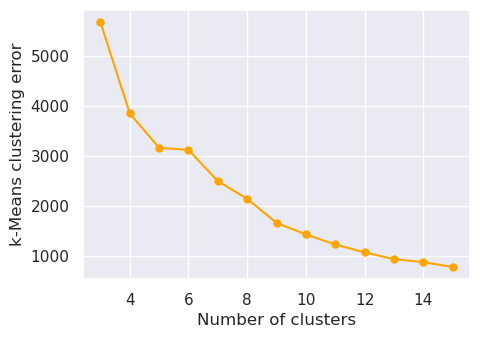

In [140]:
# Step 3
# Plot k-Means clustering error 
# Set up Seaborn style
sns.set(style="darkgrid")
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, inertia_list, marker='o', markersize=5, color='orange')
plt.xlabel('Number of clusters')
plt.ylabel('k-Means clustering error')
#plt.title('k-Means Clustering Error')
plt.show()

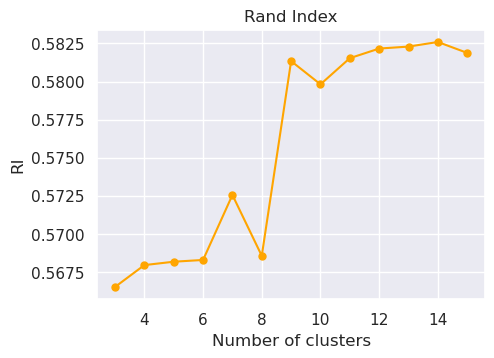

In [141]:
# Plot RI
# Set up Seaborn style
sns.set(style="darkgrid")

plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, ri_list[:13], marker='o', markersize=5, color='orange')
plt.xlabel('Number of clusters')
plt.ylabel('RI')
plt.title('Rand Index')
plt.show()

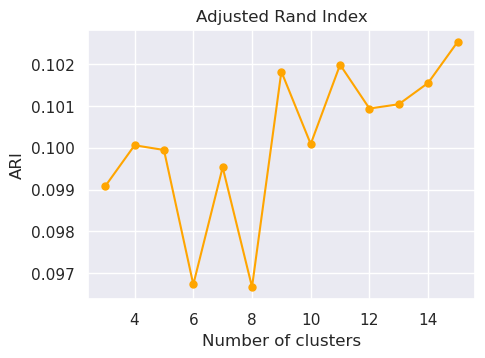

In [142]:
# Plot ARI
# Set up Seaborn style
sns.set(style="darkgrid")

plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, ari_list, marker='o', markersize=5, color='orange')
plt.xlabel('Number of clusters')
plt.ylabel('ARI')
plt.title('Adjusted Rand Index')
plt.show()

**3.3. Visualize the clusters through t-SNE visualization.**

**3.4. Cluster analysis. Analyze the characteristics of each cluster. This might involve examining the most frequent words in each cluster (try word cloud). Try to understand which are the most
representative.**

**3.5. Do clusters reflect intent division, i.e., are the clusters homogeneous in terms of intents? How are intents divided into the clusters?**

**3.6. Find clusters of similar attacks, study their sessions and try to associate with them specific categories of attacks (more fine grained than the ones of MITRE ATT&CK Tactics). As an example, see the image below, where we perform a similar exercise (through graph community detections). NOTE: you do not have to do this exercise for all the clusters, but only on some examples.**

<br><left><b><font size=4>Section 4 – Language Models exploration<b><left>

<div style="text-align: justify">Experiment language models for solving the same supervised task as in Section 2. In this task, the objective is to harness the capabilities of language models like Bert or Word2Vec, for supervised learning (assign intents to sessions). 
<br><br> Two interesting concepts play a role when we use neural networks:
<div style="text-align: justify"><br><b>1)</b> It is possible to do transfer learning, i.e., to take a model that have been trained with other enormous datasets by Big Tech companies, and we can do fine-tuning i.e., to train this model starting from its pre-trained version.
<br><b>2)</b> In NLP tasks, words/documents are transformed into vectors (encoding) and this task is Unsupervised, so we can use a much larger amount of data.
</div>

<div style="text-align: justify"><b>4.1. If you choose Doc2Vec: pretrain Doc2Vec on body column of the session text. If you chose Bert: take the pretrained Bert model like in this example. (NB: In this tutorial they used BertForSequenceClassification, but if you want to continue with step 2, you must take an other Bert implementation from HuggingFace)</div></b>

##### Data Preparation

In [ ]:
df_original = pd.read_parquet('ssh_attacks.parquet')
data = df_original.copy()
data

session_id                                       full_session  \
0                0  enable ; system ; shell ; sh ; cat /proc/mount...   
1                1  enable ; system ; shell ; sh ; cat /proc/mount...   
2                2  enable ; system ; shell ; sh ; cat /proc/mount...   
3                3  enable ; system ; shell ; sh ; cat /proc/mount...   
4                4  enable ; system ; shell ; sh ; cat /proc/mount...   
...            ...                                                ...   
233030      233042  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233031      233043  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233032      233044  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233033      233045  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233034      233046  cat /proc/cpuinfo | grep name | wc -l ; echo -...   

                         first_timestamp               Set_Fingerprint  
0       2019-06-04 09:45:11.151186+00:00  [Defense Evasion, Discovery]  
1       2019-06-04 09:45:50.396610+00:00  [Defense Evasion, Discovery]  
2       2019-06-04 09:54:41.863315+00:00  [Defense Evasion, Discovery]  
3       2019-06-04 10:22:14.623875+00:00  [Defense Evasion, Discovery]  
4       2019-06-04 10:37:19.725874+00:00  [Defense Evasion, Discovery]  
...                                  ...                           ...  
233030  2020-02-29 23:47:28.217237+00:00      [Discovery, Persistence]  
233031  2020-02-29 23:49:01.009046+00:00      [Discovery, Persistence]  
233032  2020-02-29 23:56:18.827281+00:00      [Discovery, Persistence]  
233033  2020-02-29 23:56:56.263104+00:00      [Discovery, Persistence]  
233034  2020-02-29 23:59:22.199490+00:00      [Discovery, Persistence]  

[233035 rows x 4 columns]

In [ ]:
def clean_text(text):
    # Filter out non-alphabetic characters and convert to lowercase
    cleaned_text = ' '.join(word.lower() for word in text.split() if word.isalpha())
    return cleaned_text

# Apply text cleaning to the 'full_session' column
data['cleaned_session'] = data['full_session'].apply(clean_text)

In [ ]:
# Tokenize 'cleaned_session' texts and create tagged documents
tagged_data = [TaggedDocument(words=session.split(), tags=[str(i)]) for i, session in enumerate(data['cleaned_session'])]

##### Building and Training Doc2Vec Model

<div style="text-align: justify">Cleaning the text data by removing non-alphabetic characters and converting text to lowercase. The Gensim library was used to train a Doc2Vec model on the cleaned text data. A vocabulary was buildt and the Doc2Vec model was trained to generate the vector of embeddings for each session text.</div>

In [ ]:
# Initialize the Doc2Vec model
doc2vec_model = Doc2Vec(vector_size=100, window=5, min_count=1, epochs=20, dm=1)

# Build vocabulary
doc2vec_model.build_vocab(tagged_data)

# Train the model
doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

##### Saving the Trained Model

In [ ]:
# Save the trained model
doc2vec_model.save('trained_doc2vec_model.model')

**4.2. Add a last Dense Layer**

<div style="text-align: justify">We have trained the Doc2Vec model, which generated embeddings for our text data. Now, to perform classification, we will build a simple Neural Network that will take these embeddings and will add a dense layer for the classification task. The dense layer will have as many neurons as the number of classes we want to predict.</div>

Created a neural network model using TensorFlow/Keras. Set up the architecture by adding a Dense layer with the input dimension being the size of the Doc2Vec vectors and a final Dense layer with softmax activation for multi-class classification.

In [ ]:
# Initialize a sequential model
model = Sequential()

# Add the Doc2Vec embeddings as the input layer
input_dim = doc2vec_model.vector_size
model.add(Dense(input_dim, input_shape=(input_dim,), activation='relu'))

2023-12-21 21:03:15.152119: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-12-21 21:03:15.152161: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-21 21:03:15.152203: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-s296675): /proc/driver/nvidia/version does not exist
2023-12-21 21:03:15.152550: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Add the final dense layer for classification
num_classes = 7
model.add(Dense(num_classes, activation='softmax'))  # Softmax activation for multi-class classification
#This code adds the final dense layer for classification on top of the Doc2Vec embeddings. num_classes represents the number of output classes we have in our classification task (in our case, the 7 different intents). The softmax activation function is used here as it's suitable for multi-class classification tasks, providing probabilities for each class.
#The purpose of this code is to create a neural network architecture suitable for classification using the Doc2Vec embeddings as input features. 

<div style="text-align: justify">To compile the model, we'll need to set a few parameters:<br>

- Optimizer: The optimizer adjusts the weights during training to minimize the loss function.
- Loss Function: For multi-class classification, 'categorical_crossentropy' is commonly used.
- Metrics: These are used to judge the performance of the model. For classification tasks, 'accuracy' is a standard metric.</div>

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#Categorical Crossentropy: This loss function is suitable for multi-class classification problems. It measures the dissimilarity between the true distribution and the predicted distribution of the classes.
#Accuracy: It calculates the accuracy of the model, i.e., the number of correctly predicted instances divided by the total number of instances.

**4.3. Fine-tune the last layer of the network on the supervised training set for N epochs.**

<div style="text-align: justify">Once the dataset was divided into training and validation sets. Converted the data into TensorFlow tensors. Fit the neural network model using the training set, specifying the number of epochs and batch size.</div>

In [ ]:
data

session_id                                       full_session  \
0                0  enable ; system ; shell ; sh ; cat /proc/mount...   
1                1  enable ; system ; shell ; sh ; cat /proc/mount...   
2                2  enable ; system ; shell ; sh ; cat /proc/mount...   
3                3  enable ; system ; shell ; sh ; cat /proc/mount...   
4                4  enable ; system ; shell ; sh ; cat /proc/mount...   
...            ...                                                ...   
233030      233042  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233031      233043  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233032      233044  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233033      233045  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233034      233046  cat /proc/cpuinfo | grep name | wc -l ; echo -...   

                         first_timestamp               Set_Fingerprint  \
0       2019-06-04 09:45:11.151186+00:00  [Defense Evasion, Discovery]   
1       2019-06-04 09:45:50.396610+00:00  [Defense Evasion, Discovery]   
2       2019-06-04 09:54:41.863315+00:00  [Defense Evasion, Discovery]   
3       2019-06-04 10:22:14.623875+00:00  [Defense Evasion, Discovery]   
4       2019-06-04 10:37:19.725874+00:00  [Defense Evasion, Discovery]   
...                                  ...                           ...   
233030  2020-02-29 23:47:28.217237+00:00      [Discovery, Persistence]   
233031  2020-02-29 23:49:01.009046+00:00      [Discovery, Persistence]   
233032  2020-02-29 23:56:18.827281+00:00      [Discovery, Persistence]   
233033  2020-02-29 23:56:56.263104+00:00      [Discovery, Persistence]   
233034  2020-02-29 23:59:22.199490+00:00      [Discovery, Persistence]   

                                          cleaned_session  
0       enable system shell sh cat saemw cd cat cp sae...  
1       enable system shell sh cat iywzo cd cat cp iyw...  
2       enable system shell sh cat rlnqf cd cat cp rln...  
3       enable system shell sh cat ahylk cd cat cp ahy...  
4       enable system shell sh cat idqbw cd cat cp idq...  
...                                                   ...  
233030  cat grep name wc echo passwd bash echo passwd ...  
233031  cat grep name wc echo passwd bash echo passwd ...  
233032  cat grep name wc echo passwd bash echo passwd ...  
233033  cat grep name wc echo passwd bash echo passwd ...  
233034  cat grep name wc echo passwd bash echo passwd ...  

[233035 rows x 5 columns]

In [ ]:
# Load the trained Doc2Vec model
doc2vec_model = Doc2Vec.load('trained_doc2vec_model.model') 

# Function to infer vectors for each document
def infer_vector(text):
    return doc2vec_model.infer_vector(text.split())

# Apply inference to each text and store the vectors in a new column
data['doc2vec_vectors'] = data['cleaned_session'].apply(infer_vector)

# Extract vectors and convert to array for modeling
X = np.array(data['doc2vec_vectors'].tolist())

In [ ]:
data['doc2vec_vectors']

0         [-0.08321529, 0.0077449465, -0.06652881, -0.01...
1         [-0.089439005, 0.0065259733, -0.0781171, -0.09...
2         [-0.09951109, 0.043720316, -0.13950747, -0.069...
3         [-0.08069562, 0.011613302, -0.095041774, -0.04...
4         [-0.040713, 0.06321481, -0.11676825, -0.094988...
                                ...                        
233030    [0.05556794, 0.018216267, 0.05491541, -0.00996...
233031    [-0.0035696514, -0.05770838, -0.07827665, -0.0...
233032    [0.030541396, -0.05808881, -0.020296237, -0.04...
233033    [0.03633845, 0.01279815, -0.030108368, -0.0229...
233034    [0.055527218, -0.05532907, -0.0042853295, -0.0...
Name: doc2vec_vectors, Length: 233035, dtype: object

In [ ]:
X = data['doc2vec_vectors']  
y = data['Set_Fingerprint'] 

# Split the data into training and test sets (70% train, 30% test)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42)

# Print the shapes 
print(f"X_train shape: {X_train1.shape}, y_train shape: {y_train1.shape}")
print(f"X_test shape: {X_test1.shape}, y_test shape: {y_test1.shape}")

X_train shape: (163124,), y_train shape: (163124,)
X_test shape: (69911,), y_test shape: (69911,)


In [ ]:
mlb = MultiLabelBinarizer()
y_train1_mlb = mlb.fit_transform(y_train1)
y_test1_mlb = mlb.transform(y_test1)

In [ ]:
import tensorflow as tf
X_train_array = np.array(X_train1.tolist())
X_test_array = np.array(X_test1.tolist())

X_train_tensor = tf.convert_to_tensor(X_train_array)
X_test_tensor = tf.convert_to_tensor(X_test_array)
y_train_tensor = tf.convert_to_tensor(y_train1_mlb)
y_test_tensor = tf.convert_to_tensor(y_test1_mlb)

In [ ]:
type(y_train1_mlb)

numpy.ndarray

In [ ]:
from tensorflow.keras.models import clone_model
cloned_model = clone_model(model)
cloned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = cloned_model.fit(X_train_tensor, y_train_tensor, epochs=10, batch_size=32, validation_data=(X_test_tensor, y_test_tensor))
#Epoch: An epoch represents one complete pass through the entire training dataset.
#Number of Epochs: It determines the number of times the learning algorithm will work through the entire training dataset
#Batch: The training data is divided into batches. The model is trained on each batch, and the weights are updated after each batch.
#Batch Size: It's the number of samples processed before the model is updated. Smaller batch sizes offer faster training but may be less stable than larger batch sizes.
#model.fit(): This function fits the model on the training data. It iterates over a fixed number of epochs and updates the model's weights based on the backpropagation of errors.

Epoch 1/10
5098/5098 [==============================] - 17s 3ms/step - loss: 262.0579 - accuracy: 0.6046 - val_loss: 605.8436 - val_accuracy: 0.6394
Epoch 2/10
5098/5098 [==============================] - 15s 3ms/step - loss: 1054.5090 - accuracy: 0.6465 - val_loss: 1535.7632 - val_accuracy: 0.8307
Epoch 3/10
5098/5098 [==============================] - 16s 3ms/step - loss: 1902.4349 - accuracy: 0.6744 - val_loss: 2347.0505 - val_accuracy: 0.7872
Epoch 4/10
5098/5098 [==============================] - 16s 3ms/step - loss: 3075.2815 - accuracy: 0.6754 - val_loss: 3886.2654 - val_accuracy: 0.8269
Epoch 5/10
5098/5098 [==============================] - 16s 3ms/step - loss: 4708.1436 - accuracy: 0.6534 - val_loss: 5669.7295 - val_accuracy: 0.8971
Epoch 6/10
5098/5098 [==============================] - 16s 3ms/step - loss: 6642.9492 - accuracy: 0.6327 - val_loss: 7742.5562 - val_accuracy: 0.9079
Epoch 7/10
5098/5098 [==============================] - 16s 3ms/step - loss: 8753.7275 - accurac

<div style="text-align: justify">When using <i>'tf.function'</i>, TensorFlow creates a graph representation of the computation for optimization. However, certain operations, especially those involving variable creation, can cause issues within the graph when the function is called multiple times. <br><br>
Creating a new model instance or cloning the model before train it again helps to avoid conflicts caused by the pre-existing variables or the TensorFlow graph. This approach prevents potential issues that might arise from reusing the same model object within a <i>'tf.function'</i> context. Essentially, it ensures that the new training session starts with a fresh model instance, avoiding any residual state from previous training sessions that might interfere with the current one.</div><br>

**4.4 Plot the learning curves on training and validation set. After how many epochs should we stop the training?**

<div style="text-align: justify">The Matplotlib library was used to create visualisations of training and validation losses, as well as training and validation accuracy over epochs. These plots are helpful to understand how the model learns over time, showing convergence and possible overfitting or underfitting.</div><br>

<div style="text-align: justify">(Learning curves are used to understand the changes in 'loss' and 'accuracy' at each epoch. If the training accuracy is high but the validation accuracy is low, it may indicate overfitting, whereas consistently low accuracy for both may suggest underfitting).</div><br>

<div style="text-align: justify">[In summary, the process involved preparing the text data, training a Doc2Vec model to generate embeddings, constructing and training a neural network model for intent classification, and visualizing the model's learning progress. The aim is to build a model that effectively identifies attack session intents using text data and Doc2Vec embeddings.]</div>

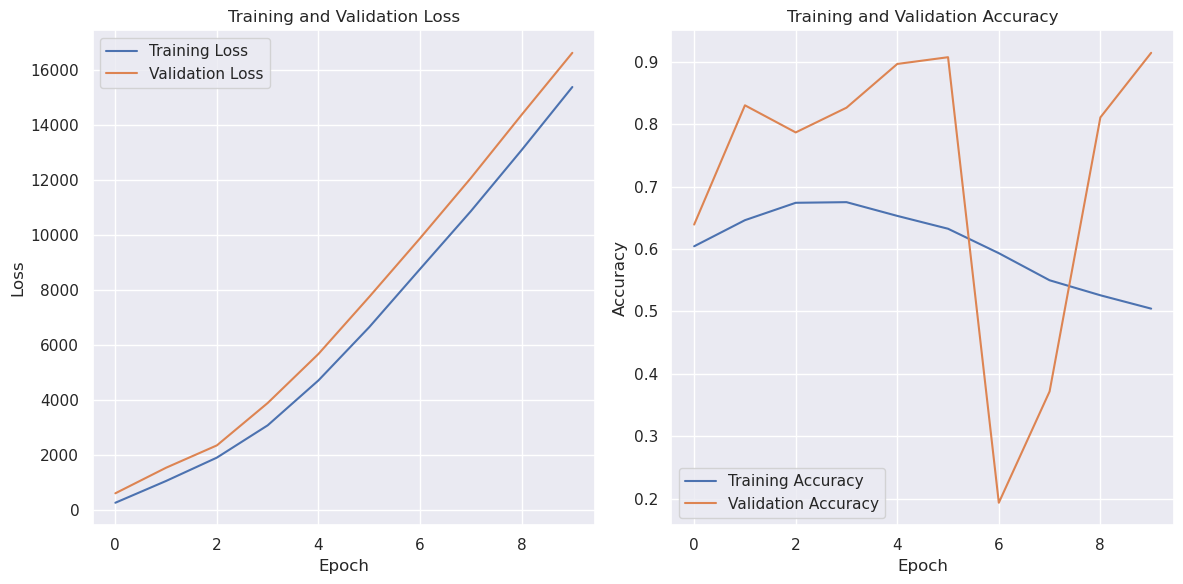

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7fd500d2fef0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/weakref.py", line 358, in remove
    def remove(k, selfref=ref(self)):
  File "/opt/cloudera/parcels/CDH/lib/spark/python/pyspark/context.py", line 257, in signal_handler
    raise KeyboardInterrupt()
KeyboardInterrupt: 


In [ ]:
# Access the training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Set up Seaborn style
sns.set(style="darkgrid")

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

<left><b><font size=4>Final Considerations<b><left>